# Segmenting Barachial Paraxis Using 2d UNET

## Loading Libraries

In [ ]:
!pip install segmentation-models-pytorch
!pip install -q pytorch-lightning
!pip install -q tabulate
from PIL import Image

import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from tabulate import tabulate
import torch
from PIL import Image
import random

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from sklearn import preprocessing as pre
import numpy as np
import cv2
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=c4763bc652ee8d6cace93228d7bb1ba36e10a5a5eafe1c103f859fdb611e6a1a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=4f001e555dd2d0fb303af802b7dea81e553e7854aa45df38ab8e6fd3d7e1bd2b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    fig=plt.figure(figsize=(10, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Dataset Into Memory (limit on 10 nifti files)

### Helper Functions

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

def filter_mask_based(mask):
  indices=[]
  for i in range(mask.shape[2]):
    if np.max(mask[:,:,i])==0:
      indices.append(i)
  return indices


def read_nifti(path,diffusion=100):
  file_data = nib.load(path)
  nii_file_data = file_data.get_fdata()

  if len(nii_file_data.shape)==4:
    return nii_file_data[:,:,:,diffusion]
  return nii_file_data

def get_indices(mask):
  indices=[]
  for i in range(mask.shape[2]):
    if np.max(mask[:,:,i])==0:
      indices.append(i)
  return indices

def get_fn(path):
  file_names=None
  with open(path,'r') as file:
    file_names=[i.strip('\n') for i in file.readlines()]
  return file_names

def load_train_test(train_path,val_split=0.2):
  train_scan_files=get_fn(train_path+'/scans.txt')
  train_mask_files=get_fn(train_path+'/masks.txt')

  train_scan_data=[]
  train_mask_data=[]

  for i in range(len(train_scan_files)):


    train_data=read_nifti(train_scan_files[i])
    mask_data=read_nifti(train_mask_files[i])
    ## getting indices where masks has max value of 0 i.e no mask

    indices= get_indices(mask_data)
    ##filtering those images which have no masks
    # slice_data_fil=np.delete(train_data,indices,2)
    # mask_data_fil=np.delete(mask_data,indices,2)

    slice_data_fil=train_data
    mask_data_fil=mask_data
    print("slice_shape",slice_data_fil.shape,
        "mask_shape",mask_data_fil.shape)
    train_scan_data.append(slice_data_fil)
    train_mask_data.append(mask_data_fil)
  scan_concat=np.concatenate(train_scan_data,axis=2)
  mask_concat=np.concatenate(train_mask_data,axis=2)
  train_slices,val_slices=np.split(scan_concat,[int((1-val_split)*scan_concat.shape[2])],axis=2)
  train_masks,val_masks=np.split(mask_concat,[int((1-val_split)*scan_concat.shape[2])],axis=2)
  print("Validation Split : ",val_split,"(means ",(1-val_split)*100,"% training slices and ",(val_split)*100,"% validation slices) ",
        "\nTotal Slices : ", train_slices.shape[2] + val_slices.shape[2],
        "\nnumber of training slices : ", train_slices.shape[2],
        "\nnumber of training masks : ", train_masks.shape[2],
        "\nnumber of validation slices : ", val_slices.shape[2],
        "\nnumber of validatipn masks : ", val_masks.shape[2],)
  return train_slices,val_slices,train_masks,val_masks


def load_test(test_path):
  train_scan_files=get_fn(test_path+'/scans.txt')

  train_scan_data=[]

  for i in range(len(train_scan_files)):


    train_data=read_nifti(train_scan_files[i])
    slice_data_fil=train_data
    print("slice_shape",slice_data_fil.shape)
    train_scan_data.append(np.array(slice_data_fil))

  return train_scan_data,train_scan_files



### Loading


In [ ]:
## these are directories containing text files for scans.nii and mask.nii files
## .../train/scans.txt
## .../train/masks.txt
val_split=0.2
train_path="/content/drive/MyDrive/BPI_data_clean1/Masked_Dataset/train"
test_path="/content/drive/MyDrive/BPI_data_clean1/Masked_Dataset/test"

train_slices,val_slices,train_masks,val_masks=load_train_test(train_path,val_split)

slice_shape (130, 130, 47) mask_shape (130, 130, 47)
slice_shape (130, 130, 47) mask_shape (130, 130, 47)
slice_shape (130, 130, 50) mask_shape (130, 130, 50)
slice_shape (130, 130, 50) mask_shape (130, 130, 50)
slice_shape (130, 130, 50) mask_shape (130, 130, 50)
slice_shape (130, 130, 50) mask_shape (130, 130, 50)
slice_shape (130, 130, 50) mask_shape (130, 130, 50)
slice_shape (130, 130, 50) mask_shape (130, 130, 50)
Validation Split :  0.2 (means  80.0 % training slices and  20.0 % validation slices)  
Total Slices :  394 
number of training slices :  315 
number of training masks :  315 
number of validation slices :  79 
number of validatipn masks :  79


bold text## Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

### Dataset Class

In [ ]:

# from torch.utils.data import DataLoader
# from torch.utils.data import Dataset as BaseDataset
# from sklearn import preprocessing as pre

def convert_to_rgb(image):
    # Ensure the input image has 3 channels (grayscale to RGB conversion)
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

def normalize_image(image):
    # Normalize the image between 0 and 255
    image_min = np.min(image)
    image_max = np.max(image)
    normalized_image = (image - image_min) * (255.0 / (image_max - image_min))
    normalized_image = normalized_image.astype(np.uint8)
    return normalized_image

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['spine','nerves']

    def __init__(
            self,
            images,
            masks=[],
            classes=['spine','nerves'],
            augmentation=None,
            preprocessing=None,
    ):
        self.ids=images.shape[2]
        self.images= images
        self.masks = masks

        # convert str names to class values on masks
        self.class_values = [1]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image_org = cv2.resize(convert_to_rgb(normalize_image(self.images[:,:,i]).reshape(self.images.shape[0],self.images.shape[1],1)),(256,256))

        image=image_org
        if not len(self.masks):
          if self.augmentation:
            sample = self.augmentation(image=image_org)
            image = sample['image']

        # apply preprocessing
          if self.preprocessing:
              sample = self.preprocessing(image=image_org)
              image= sample['image']
          return image


        mask= self.masks[:,:,i].reshape(256,256,1)


        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image_org, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image_org, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask.astype('uint8'), image_org

    def __len__(self):
        return self.ids

## Square And Circle Mask Generator

### Function

In [ ]:
## Following function has been written with the help of chat gpt
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt

def generate_binary_mask(shape,center_x,center_y, mask_type='circle', radius=None, length=None,length2=None, bounded_radius=None, num_points=None, path=None):
    """
    Generate a binary mask of a specific shape.

    Parameters:
        shape (tuple): The dimensions of the array in which the mask will be applied.
        mask_type (str): Type of mask to generate ('circle', 'square', 'bounded').
        radius (float): Radius of the circle.
        length (int): Length of the square's side.
        bounded_radius (float): Maximum radius of curves in the bounded area.
        num_points (int): Number of points used to generate the bounded area.

    Returns:
        numpy.ndarray: The generated binary mask.
    """

    if mask_type not in ['circle', 'square', 'bounded']:
        raise ValueError("Invalid mask_type. Please choose 'circle', 'square', or 'bounded'.")

    if len(shape) != 2:
        raise ValueError("Shape should be a tuple of two integers representing the dimensions of the array.")

    height, width = shape

    if mask_type == 'circle':
        if radius is None or radius <= 0:
            raise ValueError("Invalid radius value. Please provide a positive radius for the circle.")
        y, x = np.ogrid[:height, :width]
        mask = ((x - (width-center_x) // 2) ** 2 + (y - (height-center_y) // 2) ** 2) <= radius ** 2

    elif mask_type == 'square':
        if length is None or length <= 0:
            raise ValueError("Invalid length value. Please provide a positive length for the square.")
        mask = np.zeros(shape, dtype=bool)
        mask[(height-center_y) // 2 - length2 // 2: (height-center_y) // 2 + length2 // 2, (width-center_x) // 2 - length // 2: (width-center_x) // 2 + length // 2] = True

    else:  # mask_type == 'bounded'
        if bounded_radius is None or bounded_radius <= 0:
            raise ValueError("Invalid bounded_radius value. Please provide a positive radius for the bounded area.")
        if num_points is None or num_points <= 2:
            raise ValueError("Invalid num_points value. Please provide a number greater than 2.")
        # Generate a random polygonal bounded area
        angles = np.linspace(0, 2 * np.pi, num_points)
        points = np.array([(width // 2 + bounded_radius * np.cos(angle), height // 2 + bounded_radius * np.sin(angle)) for angle in angles])
        mask = np.zeros(shape, dtype=bool)


    return mask.astype(np.uint8)


### Visulaize Custom Masks

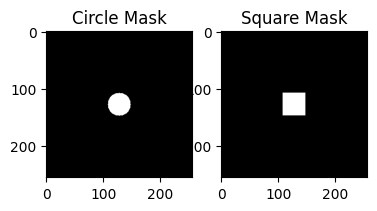

In [ ]:

# Example usage:

# center points coordinates (0,0) means center of the image.

cir_x=0
cir_y=0

sq_x=0
sq_y=0

shape = (256, 256)  # Example array dimensions (height, width)

# Generate a circle mask with radius 20
circle_mask = generate_binary_mask(shape,cir_x,cir_y, mask_type='circle', radius=20)

# Generate a square mask with length 40
square_mask = generate_binary_mask(shape,sq_x,sq_y, mask_type='square', length=40,length2=40)


# Display the masks
plt.subplot(131)
plt.imshow(circle_mask, cmap='gray')
plt.title('Circle Mask')

plt.subplot(132)
plt.imshow(square_mask, cmap='gray')
plt.title('Square Mask')

plt.show()



## Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [ ]:
import albumentations as albu
def get_training_augmentation():
    train_transform = [

        # albu.HorizontalFlip(p=0.5),

        # albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        # albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # albu.RandomCrop(height=320, width=320, always_apply=True),

        # albu.IAAAdditiveGaussianNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                # albu.RandomBrightness(p=1),
                # albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                # albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.RandomContrast(p=1),
                # albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

## Converting Binary Mask to Multi Mask
Here we divide the mask into two submask i.e spinal chord and nerves. Reason we did this is based on our observation and experiments that suggested that the region that we define as one class in 3d , appears to be at least two classes in 2d (a spinal chord and nerves along with it).  We carefully estimated the coordinates and suitable type of sub-mask for each nifti file. We can see the comparison between binary-mask and multi-mask in below visualization.

### Prepration of Multi Masks

In [ ]:
##**IM_HEIGHT,**train_multi_masks,**remove repeated code below

#1-47
#47-150
#150-195

def merged_mask(mask,center,height,width,mask_type='square'):
  # Generate a binary mask of a specific shape (like a square)
  custom_mask = generate_binary_mask(shape,center[0],center[1], mask_type=mask_type, length=width,length2=height)*2
  # Create a negative mask that is 1 where the custom_mask is 0 and 0 where the custom_mask is non-zero
  neg_mask=(custom_mask==(custom_mask*0)).astype('int')+custom_mask
  msk2=custom_mask*2
  temp_mask=mask
  merged_mask=temp_mask*neg_mask
  return merged_mask


multi_mask_train=np.ones(shape=(256,256,train_masks.shape[2]))
multi_mask_val=np.ones(shape=(256,256,val_masks.shape[2]))

binary_mask_train=np.ones(shape=(256,256,train_masks.shape[2]))
binary_mask_val=np.ones(shape=(256,256,val_masks.shape[2]))

temp_train_masks=cv2.resize(train_masks,(256,256))


center1=[33,15]
height1=40
width1=30

for i in range(47):
  mask=train_masks[:,:,i]
  ## converting raw masks[0-2] to binary[0,1] and then multi[0,1,2]
  binary_mask_train[:,:,i]=np.ceil(pre.MinMaxScaler().fit_transform(np.array(cv2.resize(mask,(256,256)))))
  multi_mask_train[:,:,i]=merged_mask(np.ceil(pre.MinMaxScaler().fit_transform(np.array(cv2.resize(mask,(256,256))))),center1,height1,width1)

center2=[5,0]
height2=40
width2=30

for i in range(47,195):
  mask=train_masks[:,:,i]
  binary_mask_train[:,:,i]=np.ceil(pre.MinMaxScaler().fit_transform(np.array(cv2.resize(mask,(256,256)))))
  multi_mask_train[:,:,i]=merged_mask(np.ceil(pre.MinMaxScaler().fit_transform(np.array(cv2.resize(mask,(256,256))))),center2,height2,width2)

center3=[50,15]
height3=40
width3=40


for i in range(195,215):
  mask=train_masks[:,:,i]
  binary_mask_train[:,:,i]=np.ceil(pre.MinMaxScaler().fit_transform(np.array(cv2.resize(mask,(256,256)))))
  multi_mask_train[:,:,i]=merged_mask(np.ceil(pre.MinMaxScaler().fit_transform(np.array(cv2.resize(mask,(256,256))))),center3,height3,width3)

for i in range(215,train_masks.shape[2]):
  mask=train_masks[:,:,i]
  binary_mask_train[:,:,i]=np.ceil(pre.MinMaxScaler().fit_transform(np.array(cv2.resize(mask,(256,256)))))
  multi_mask_train[:,:,i]=merged_mask(np.ceil(pre.MinMaxScaler().fit_transform(np.array(cv2.resize(mask,(256,256))))),center2,height2,width2)

for i in range(val_masks.shape[2]):
  mask=val_masks[:,:,i]
  binary_mask_val[:,:,i]=np.ceil(pre.MinMaxScaler().fit_transform(np.array(cv2.resize(mask,(256,256)))))
  multi_mask_val[:,:,i]=merged_mask(np.ceil(pre.MinMaxScaler().fit_transform(np.array(cv2.resize(mask,(256,256))))),center2,height2,width2)



### Visualizing

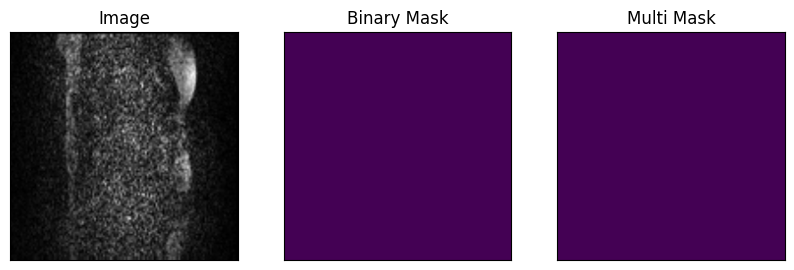

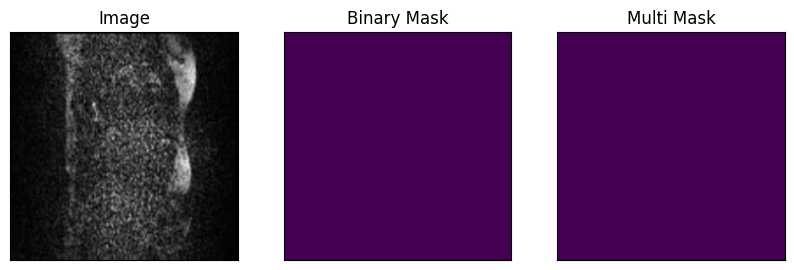

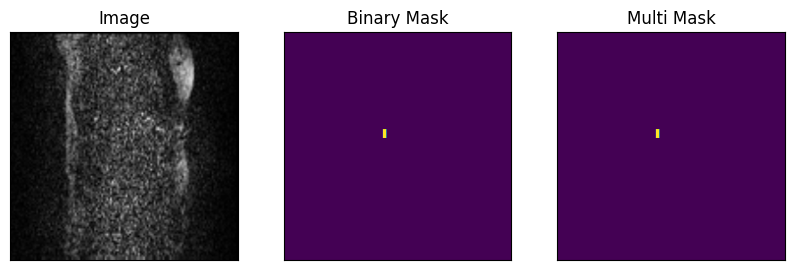

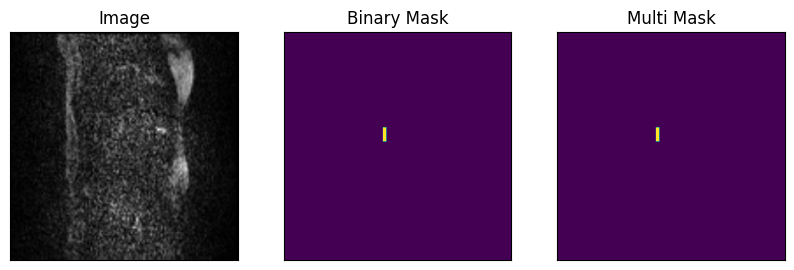

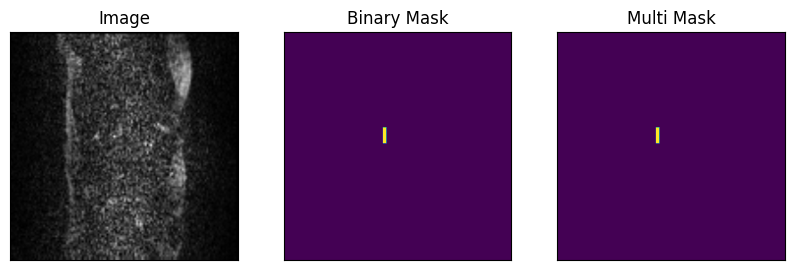

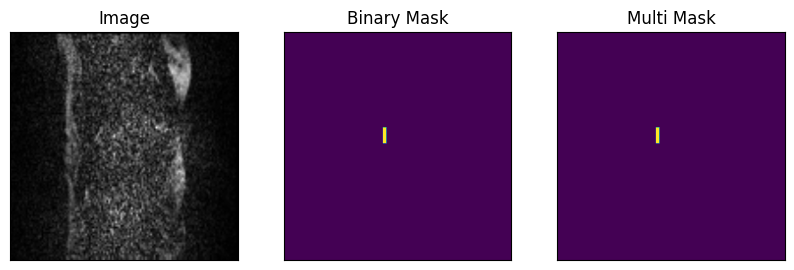

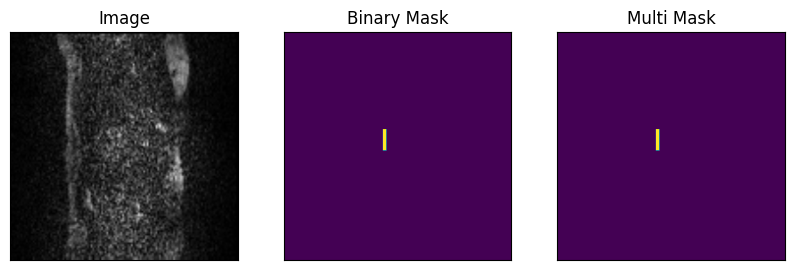

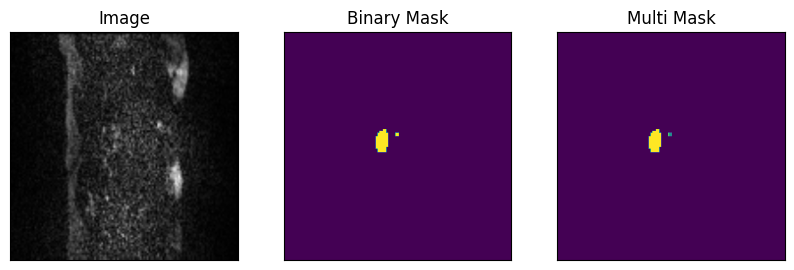

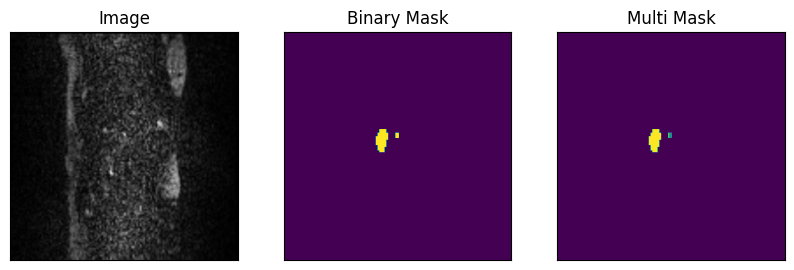

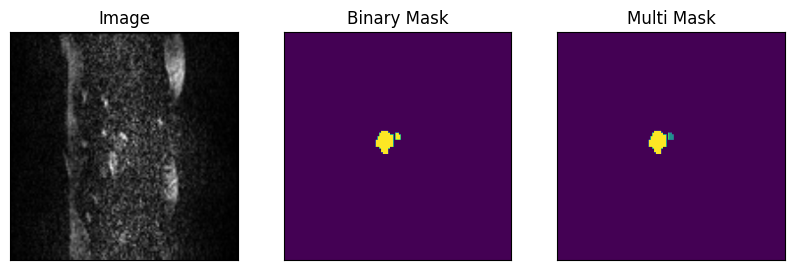

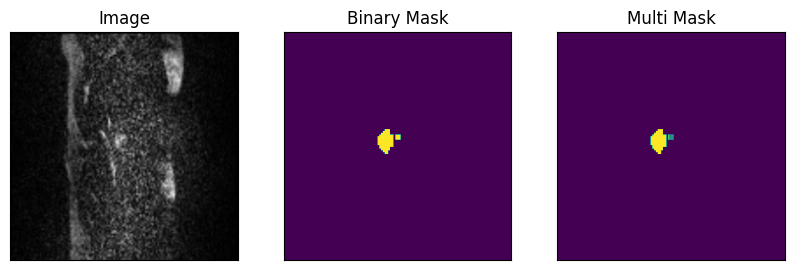

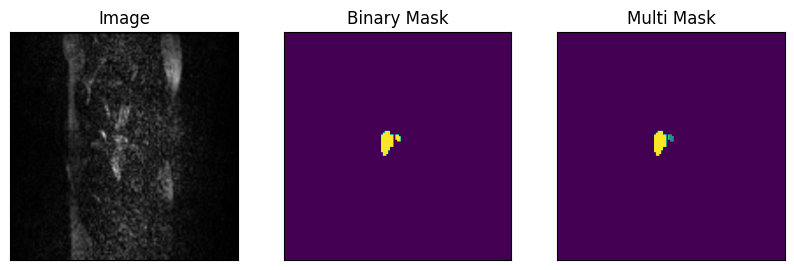

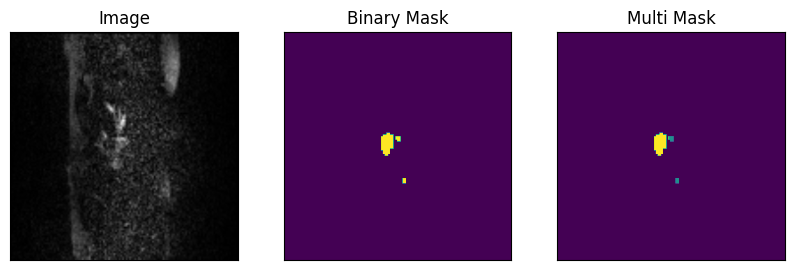

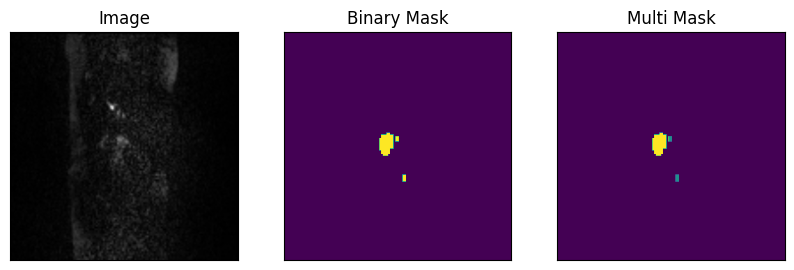

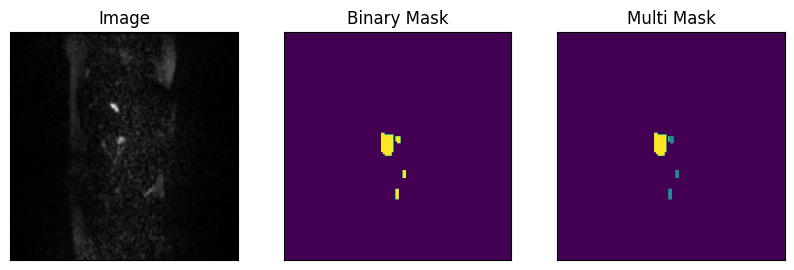

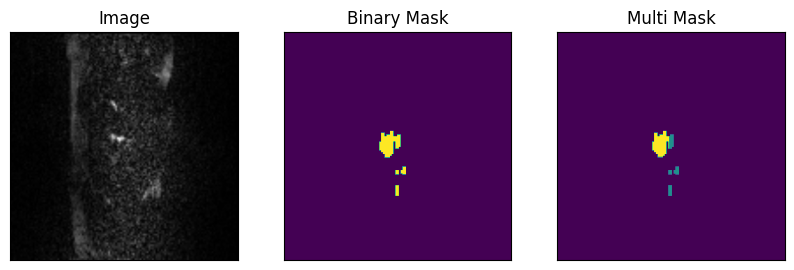

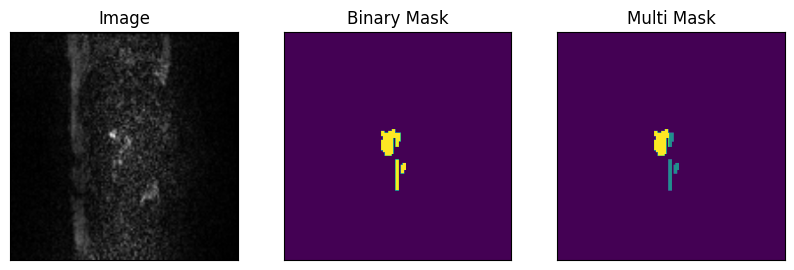

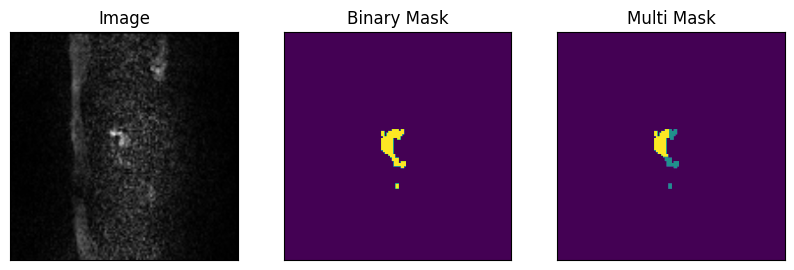

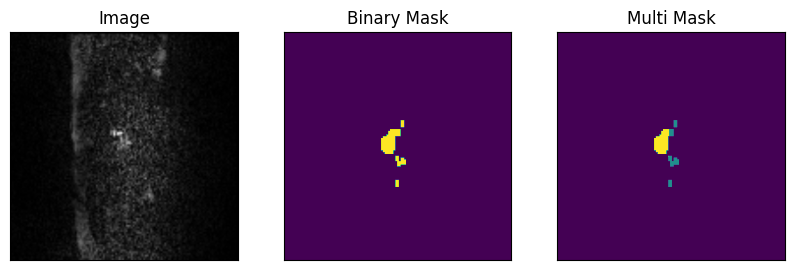

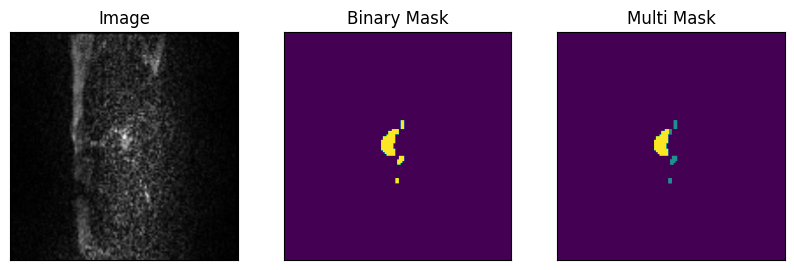

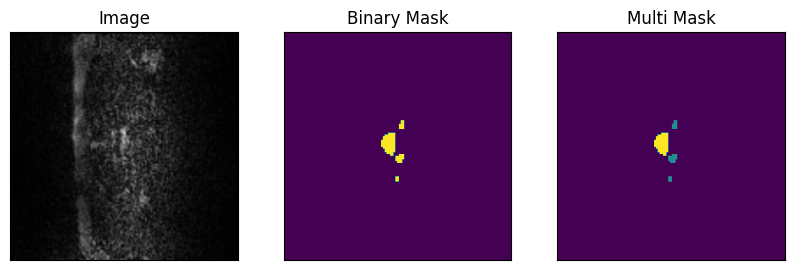

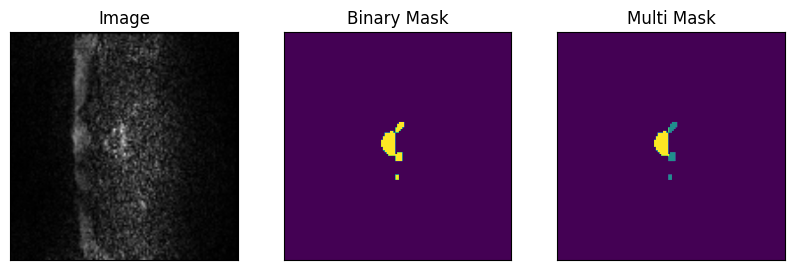

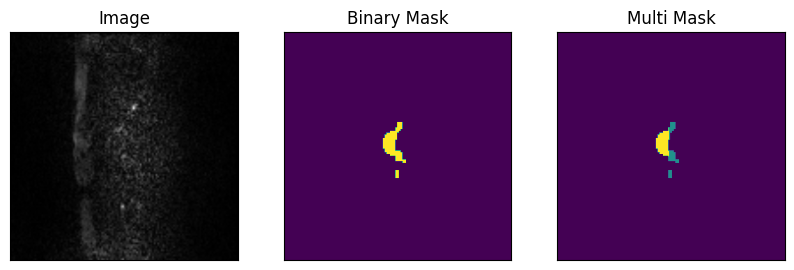

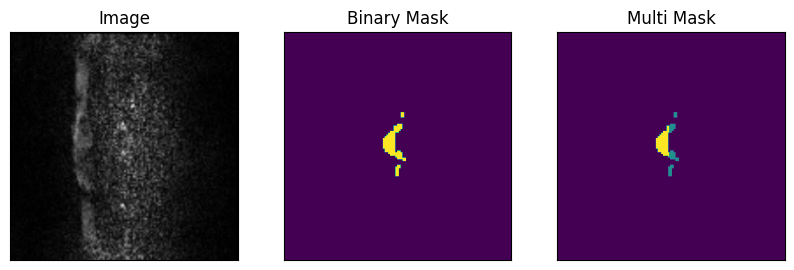

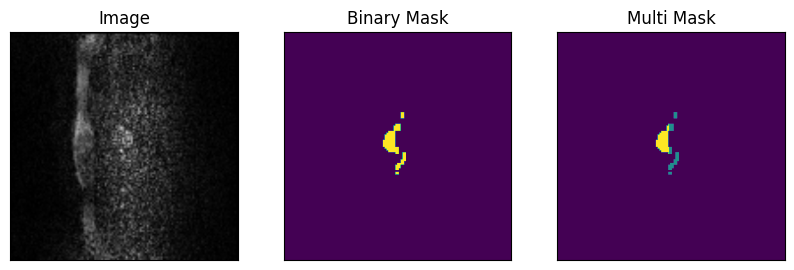

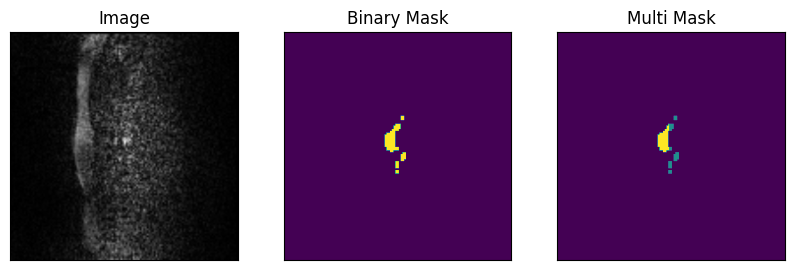

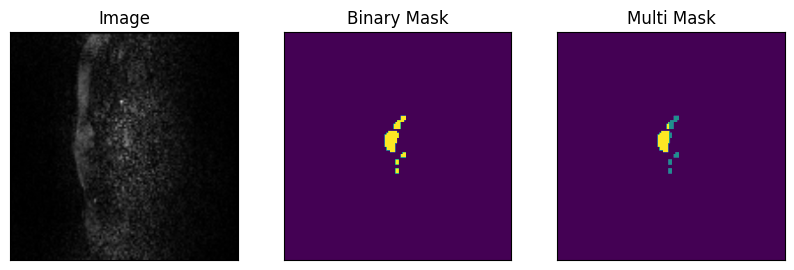

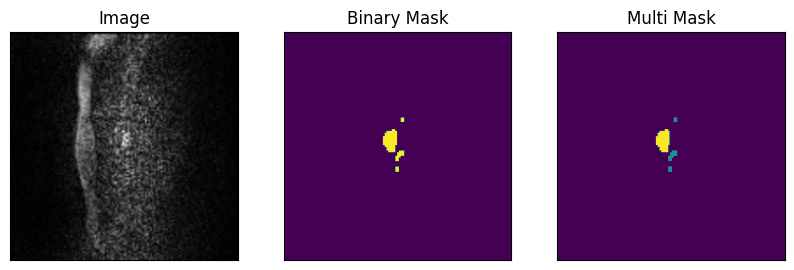

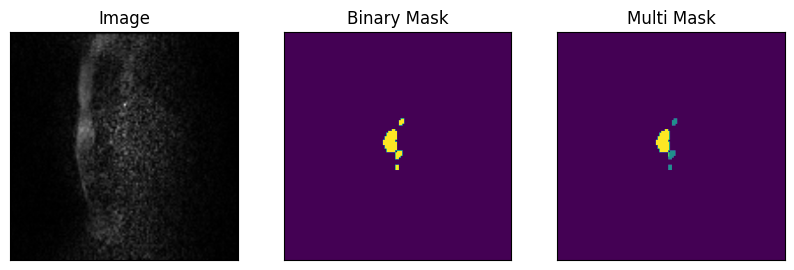

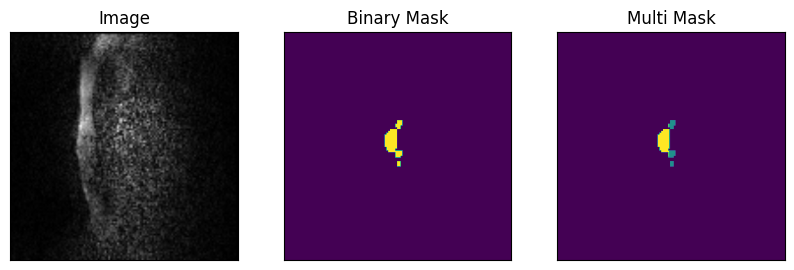

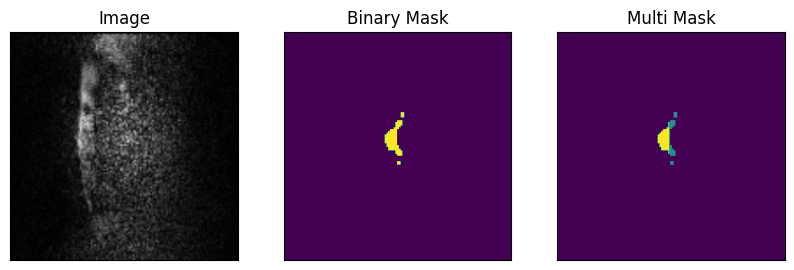

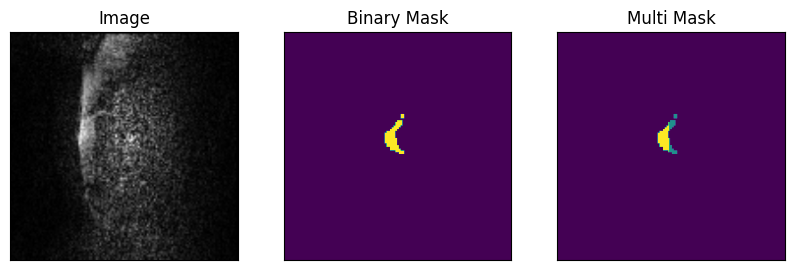

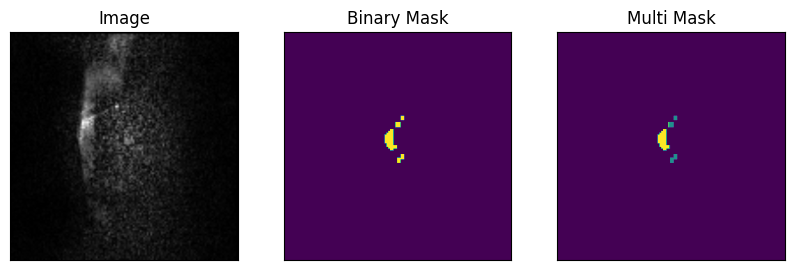

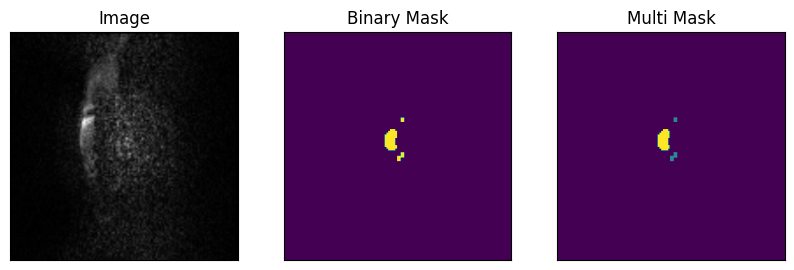

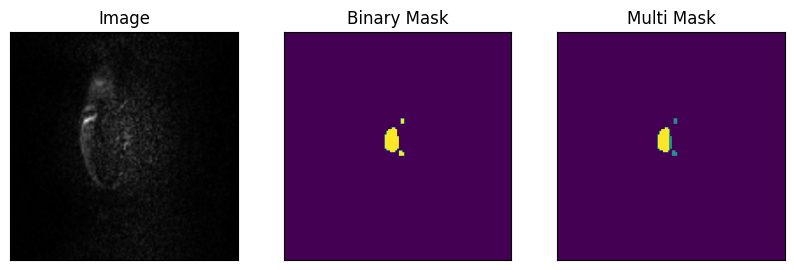

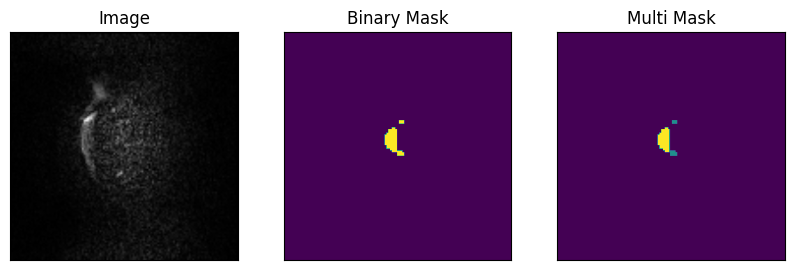

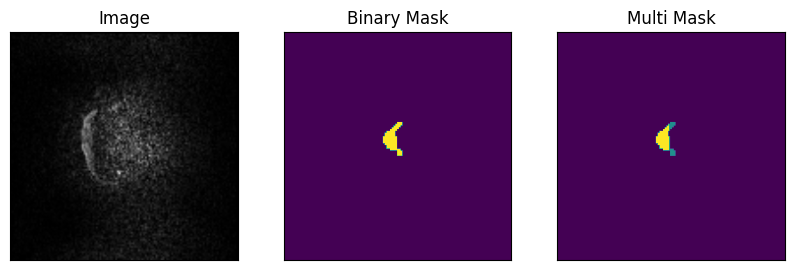

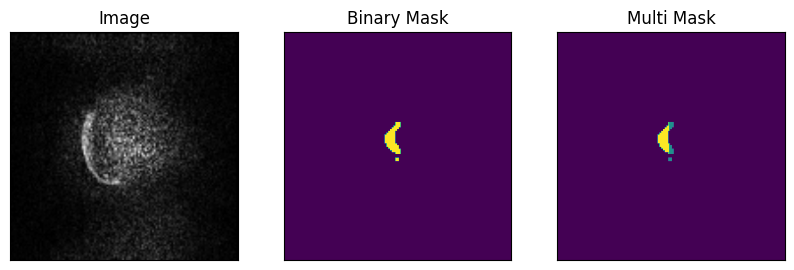

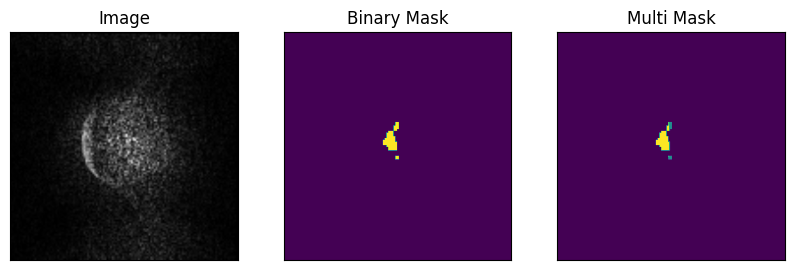

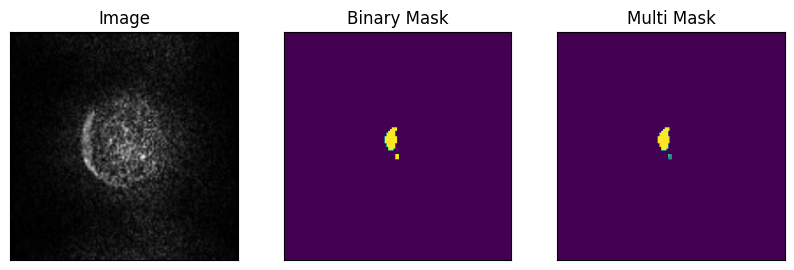

In [ ]:
#### Visualize resulted augmented images and masks

multi_mask_dataset = Dataset(
    train_slices,
    masks=multi_mask_train,
)

binary_mask_dataset = Dataset(
    train_slices,
    masks=binary_mask_train,
)
# same image with different random transforms
for i in range(0,40):
    image, multi_mask, _ = multi_mask_dataset[i]
    image, binary_mask, _ = binary_mask_dataset[i]
    visualize(image=image, binary_mask =binary_mask, multi_mask=multi_mask)

## Mulit-Class Segmention Model

### Training Class

In [ ]:
# !pip install -q segmentation-models-pytorch
# !pip install -q pytorch-lightning
# !pip install -q tabulate
# from PIL import Image

# from pytorch_lightning.loggers import TensorBoardLogger

# import segmentation_models_pytorch as smp
# import pytorch_lightning as pl
# from tabulate import tabulate



class BPS_Model(pl.LightningModule):
    def __init__(self, model, optimizer, criterion,classes=3,mode='multiclass'):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_classses=classes
        self.train_avg_loss=[]
        self.train_avg_iou=[]
        self.val_avg_loss=[]
        self.val_avg_iou=[]

    def forward(self, x):
        return self.model(x)

    def shared_step(self, batch, stage):
        image, mask,_ = batch
        out = self.forward(image)
        loss = self.criterion(out, mask.long())
        tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(out, 1).unsqueeze(1), mask.long(), mode='multiclass', num_classes = self.num_classses)
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")
        self.log(f"{stage}_IoU", iou, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_loss", loss)
        if stage=="train":
          self.train_avg_loss.append(loss.item())
          self.train_avg_iou.append(iou)
        else:
          self.val_avg_loss.append(loss.item())
          self.val_avg_iou.append(iou)



        return {"loss": loss, "iou": iou}

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def configure_optimizers(self):
        return self.optimizer

    def on_train_epoch_end(self):
        # log epoch metric

        train_epoch_metrics['loss'].append(np.mean(self.train_avg_loss))
        train_epoch_metrics['IoU'].append(np.mean(self.train_avg_iou))



    def on_validation_epoch_end(self):
        # image, mask = self.final_batch[0]

        val_epoch_metrics['loss'].append(np.mean(self.val_avg_loss))
        val_epoch_metrics['IoU'].append(np.mean(self.val_avg_iou))



### Training and Model Settings

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
arch = 'unetplusplus'
enc_name = 'resnext50_32x4d'
classes = 3
encoder_weights = "imagenet"
model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-04)
criterion = smp.losses.DiceLoss(mode='multiclass', from_logits=True).to(device)
cbs = pl.callbacks.ModelCheckpoint(dirpath = f'./checkpoints_{arch}',
                                   filename = arch,
                                   verbose = True,
                                   monitor = 'valid_loss',
                                   mode = 'min')

preprocessing_fn = smp.encoders.get_preprocessing_fn(enc_name, encoder_weights)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 60.1MB/s]


### Dataloaders

In [ ]:
train_dataset = Dataset(
    train_slices,
    multi_mask_train,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=classes,
)

valid_dataset = Dataset(
    val_slices,
    multi_mask_val,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=classes,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Training

In [ ]:
train_epoch_metrics={'loss':[],'dice_similarity':[],'IoU':[]}
val_epoch_metrics={'loss':[],'dice_similarity':[],'IoU':[]}
import torch
multi_model = BPS_Model(model, optimizer, criterion)
trainer = pl.Trainer(callbacks=cbs, accelerator=device, max_epochs=30, )
trainer.fit(multi_model, train_loader, valid_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params
-------------------------------------------
0 | model     | UnetPlusPlus | 48.5 M
1 | criterion | DiceLoss     | 0     
-------------------------------------------
48.5 M    Trainable params
0         Non-trainable params
48.5 M    Total params
193.832   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 40: 'valid_loss' reached 0.67746 (best 0.67746), saving model to '/content/checkpoints_unetplusplus/unetplusplus.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 80: 'valid_loss' reached 0.64389 (best 0.64389), saving model to '/content/checkpoints_unetplusplus/unetplusplus.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 120: 'valid_loss' reached 0.62221 (best 0.62221), saving model to '/content/checkpoints_unetplusplus/unetplusplus.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 160: 'valid_loss' reached 0.60670 (best 0.60670), saving model to '/content/checkpoints_unetplusplus/unetplusplus.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 200: 'valid_loss' reached 0.59092 (best 0.59092), saving model to '/content/checkpoints_unetplusplus/unetplusplus.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 240: 'valid_loss' reached 0.55369 (best 0.55369), saving model to '/content/checkpoints_unetplusplus/unetplusplus.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 280: 'valid_loss' reached 0.51950 (best 0.51950), saving model to '/content/checkpoints_unetplusplus/unetplusplus.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 320: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 360: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 400: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 440: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 480: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 520: 'valid_loss' reached 0.50287 (best 0.50287), saving model to '/content/checkpoints_unetplusplus/unetplusplus.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 560: 'valid_loss' reached 0.49627 (best 0.49627), saving model to '/content/checkpoints_unetplusplus/unetplusplus.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 600: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 640: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 680: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 720: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 760: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 800: 'valid_loss' reached 0.49214 (best 0.49214), saving model to '/content/checkpoints_unetplusplus/unetplusplus.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 840: 'valid_loss' reached 0.48194 (best 0.48194), saving model to '/content/checkpoints_unetplusplus/unetplusplus.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 880: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 920: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 960: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 1000: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 1040: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 1080: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 1120: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 1160: 'valid_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 1200: 'valid_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


### Plots

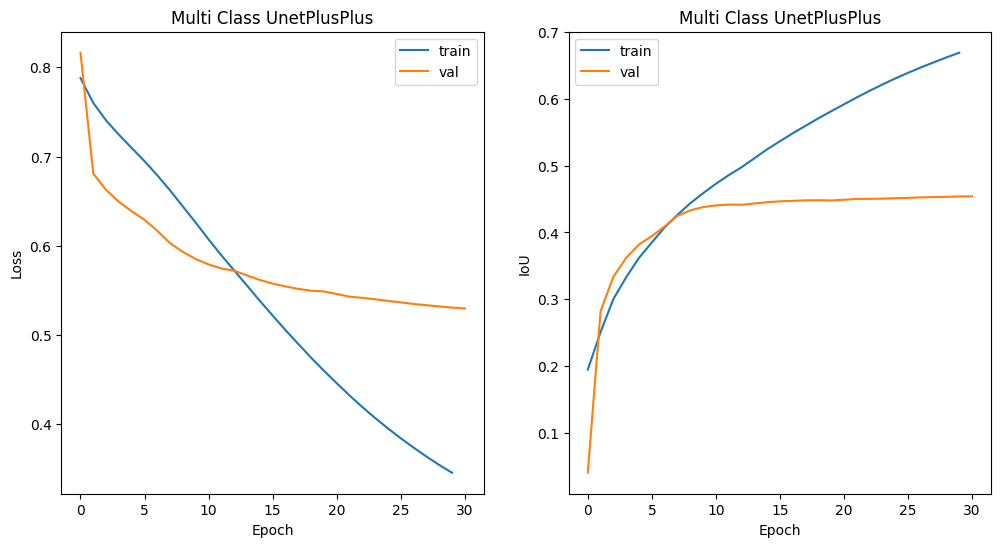

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_epoch_metrics['loss'], label='train')
plt.plot(val_epoch_metrics['loss'], label='val')
plt.title('Multi Class UnetPlusPlus')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2,2)
plt.plot( train_epoch_metrics['IoU'], label='train')
plt.plot( val_epoch_metrics['IoU'], label='val')
plt.title('Multi Class UnetPlusPlus')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()

### Visualization

In [ ]:
from collections import OrderedDict

device = "cuda" if torch.cuda.is_available() else "cpu"
arch = 'unetplusplus'
enc_name = 'resnext50_32x4d'
classes = 3
encoder_weights = "imagenet"
#best_model_ckpt='/content/drive/MyDrive/checkpoints_unet_multi/unet-v23.ckpt'
best_model_ckpt='/content/checkpoints_unetplusplus/unetplusplus.ckpt'
multi_model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

state_dict = torch.load(best_model_ckpt)['state_dict']
pl_state_dict = OrderedDict([(key[6:], state_dict[key]) for key in state_dict.keys()])

multi_model.load_state_dict(pl_state_dict)


<All keys matched successfully>

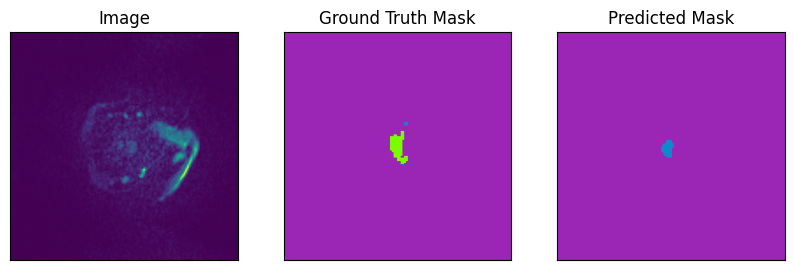

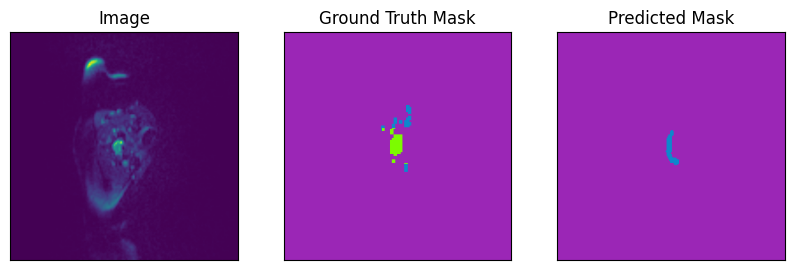

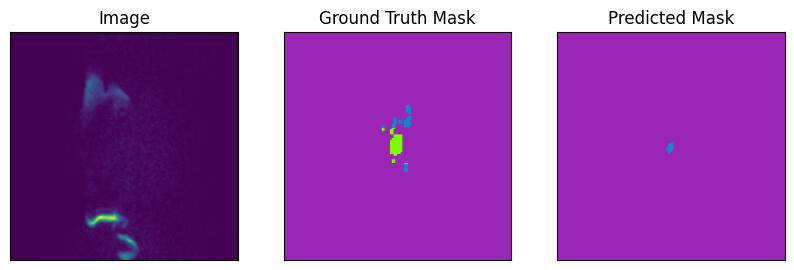

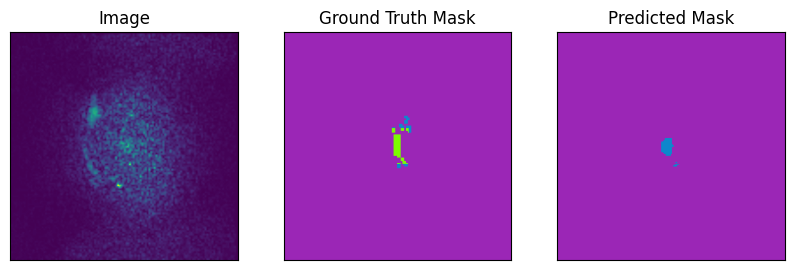

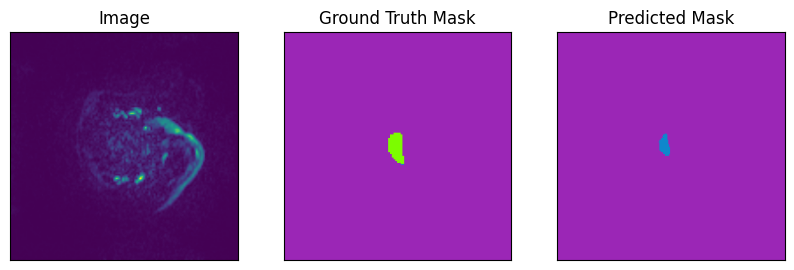

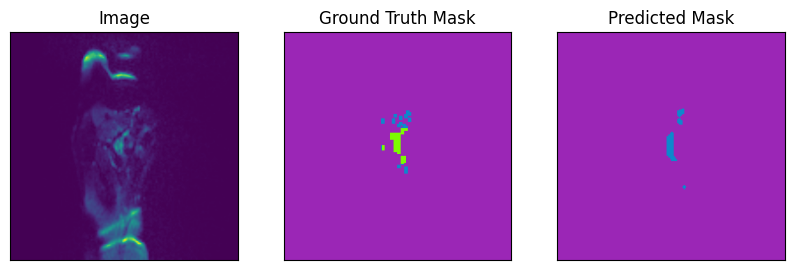

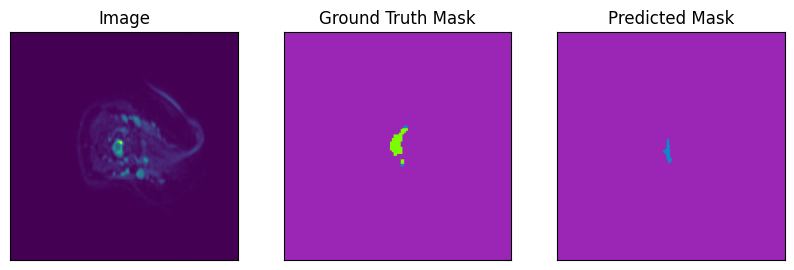

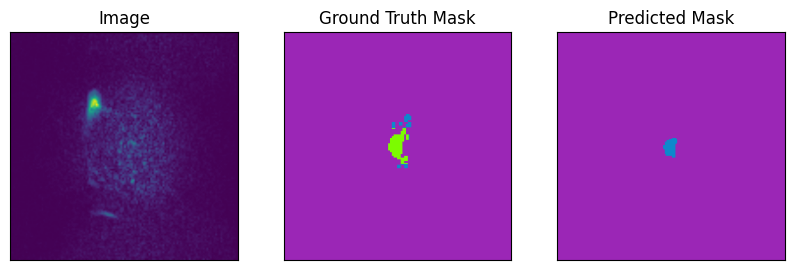

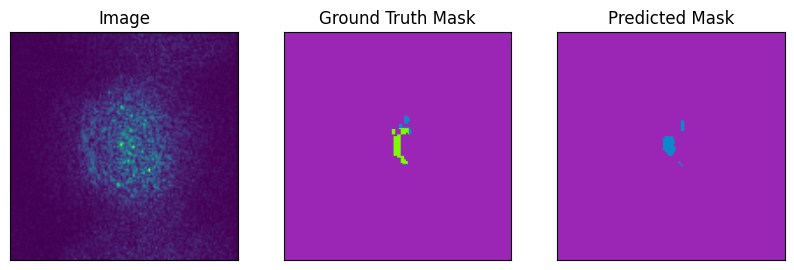

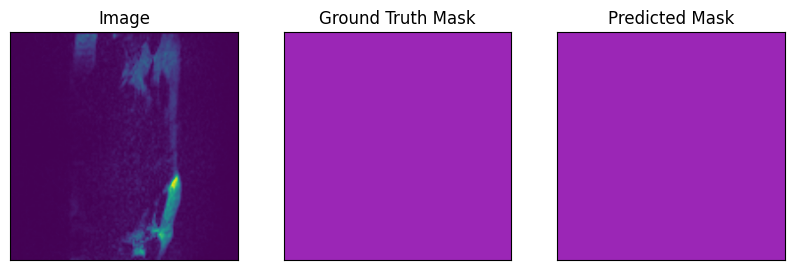

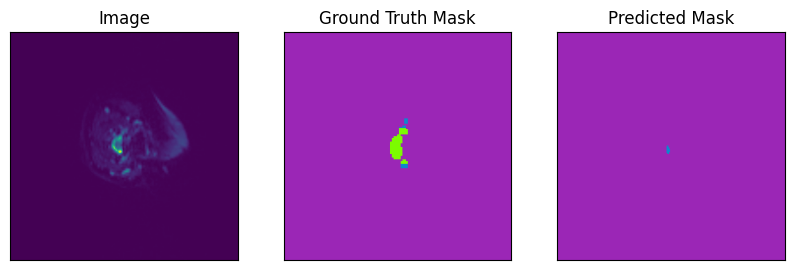

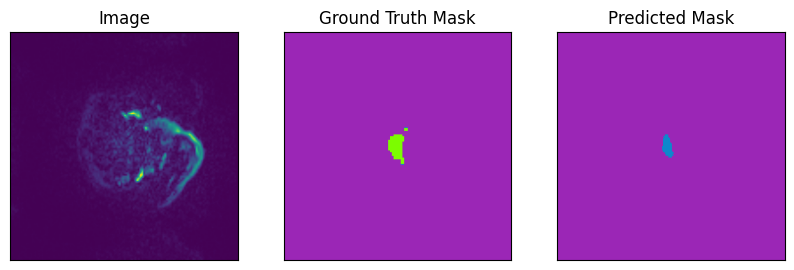

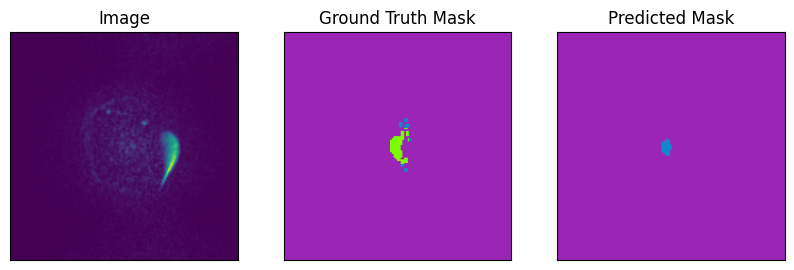

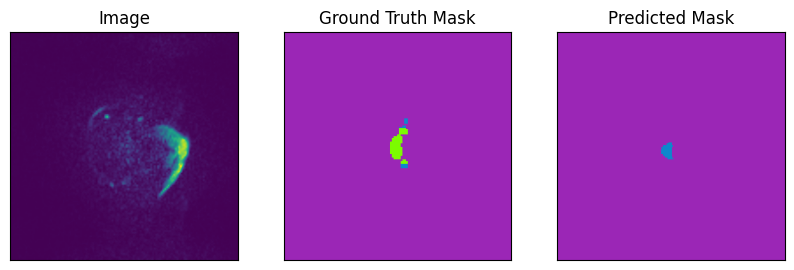

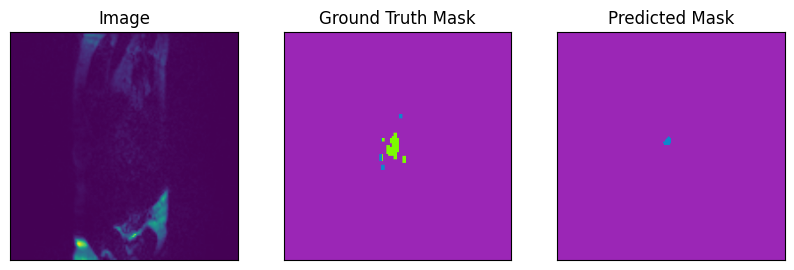

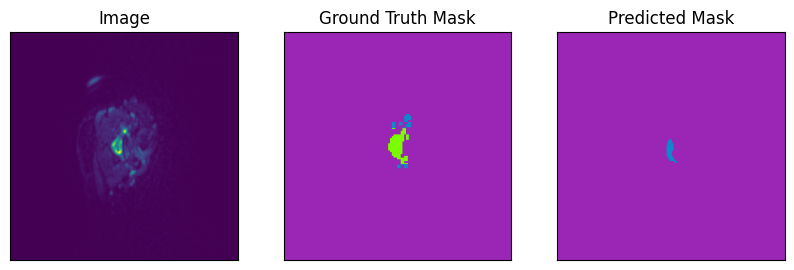

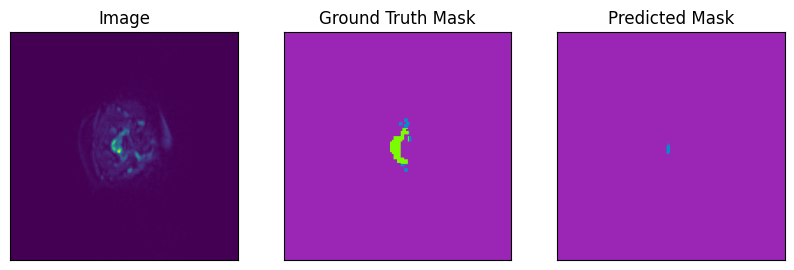

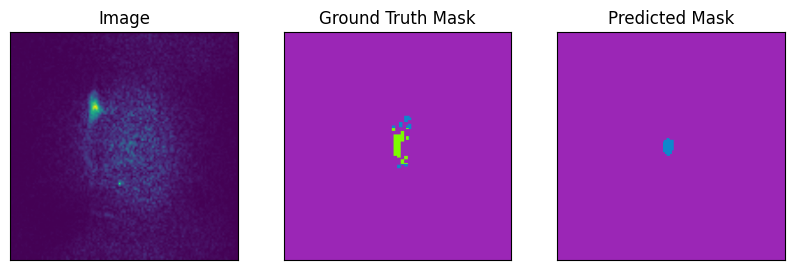

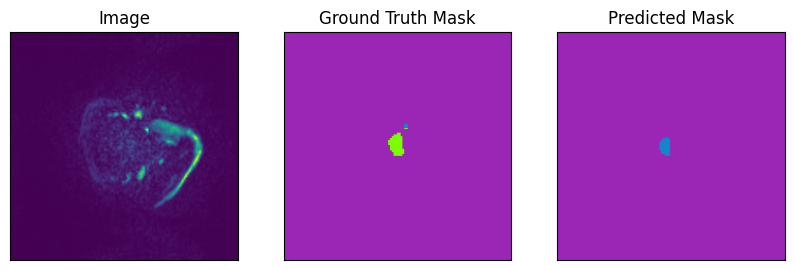

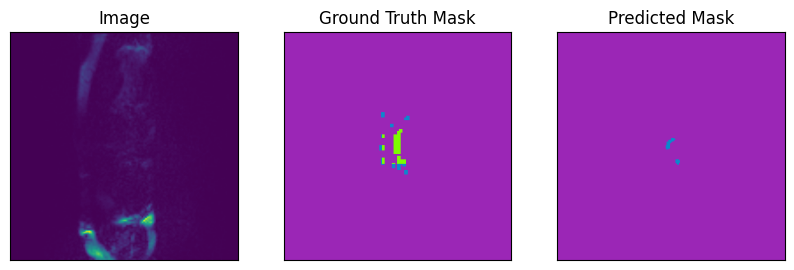

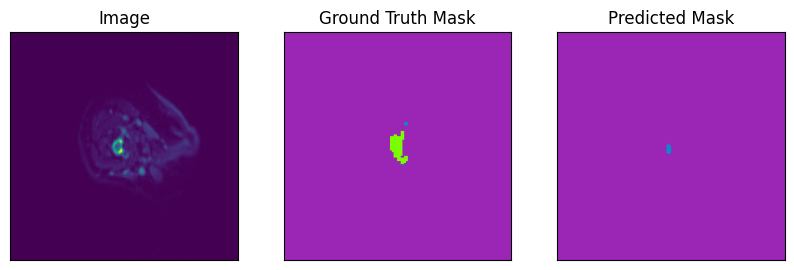

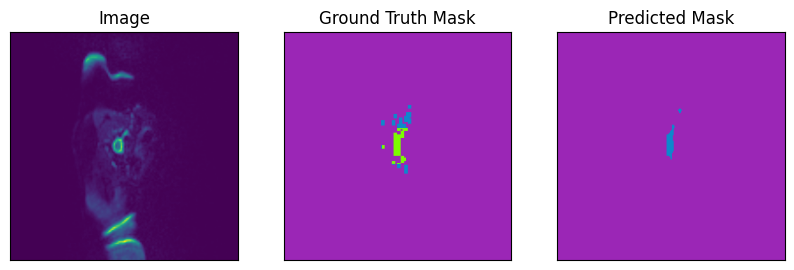

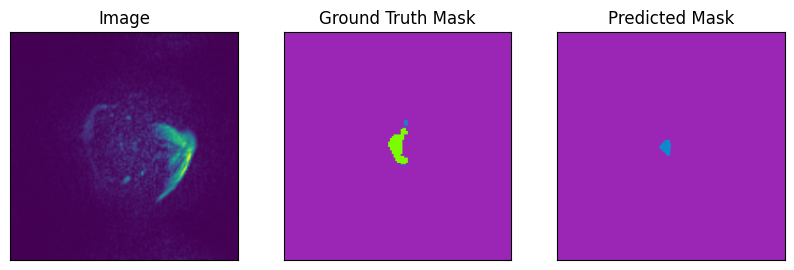

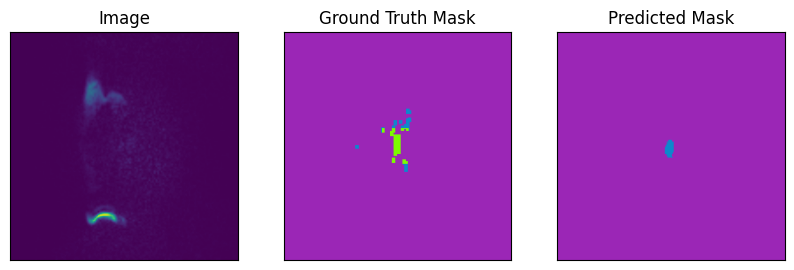

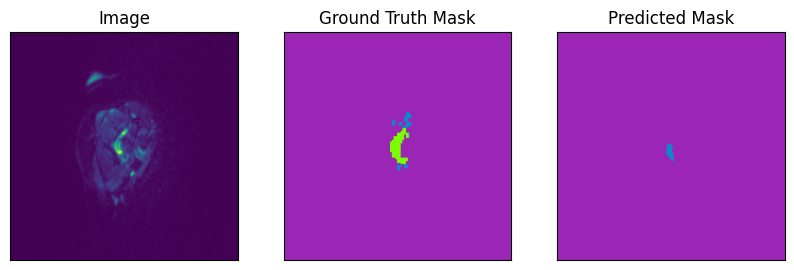

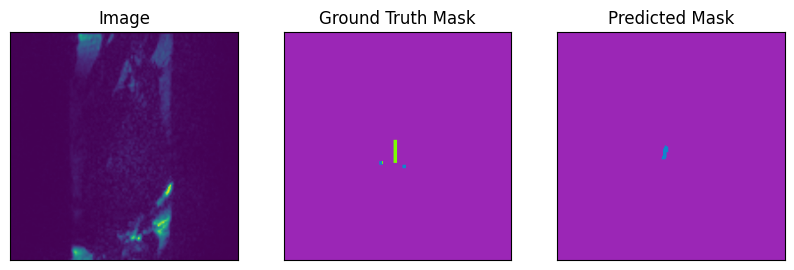

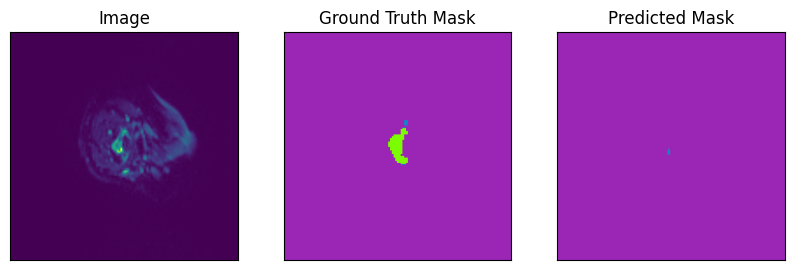

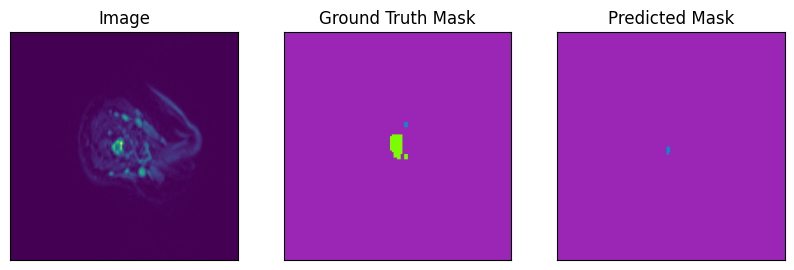

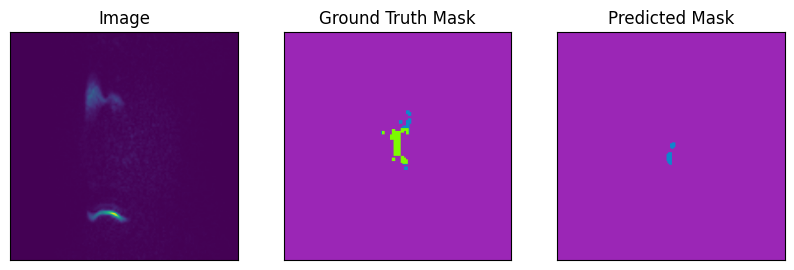

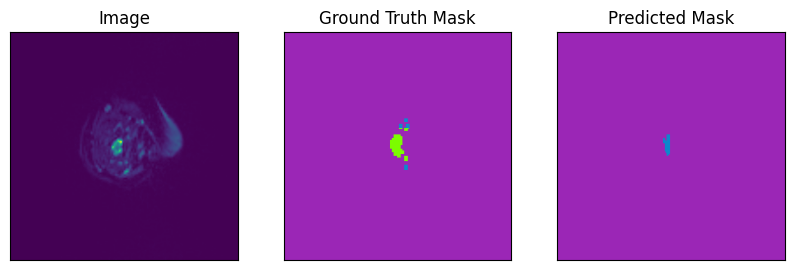

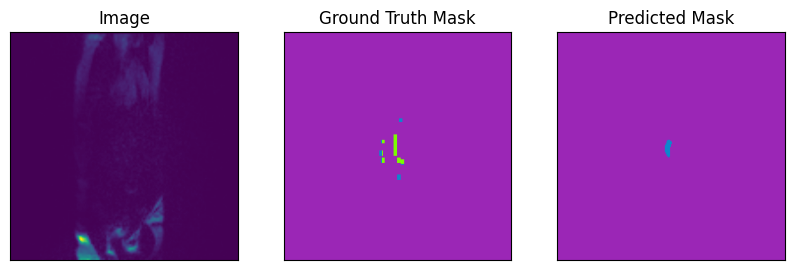

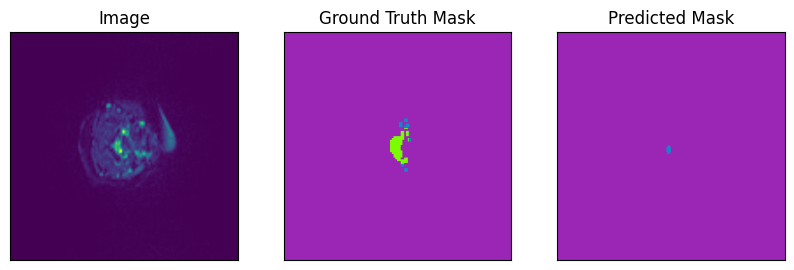

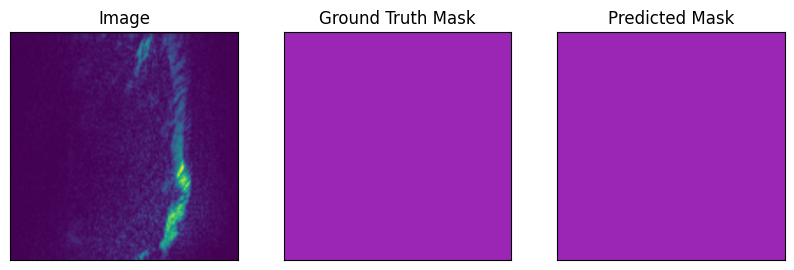

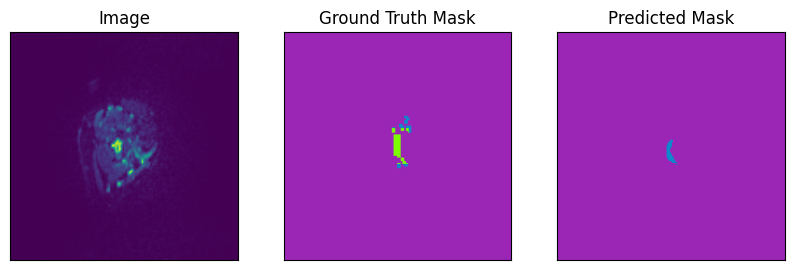

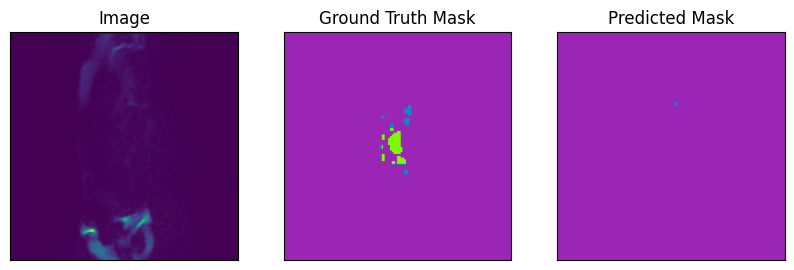

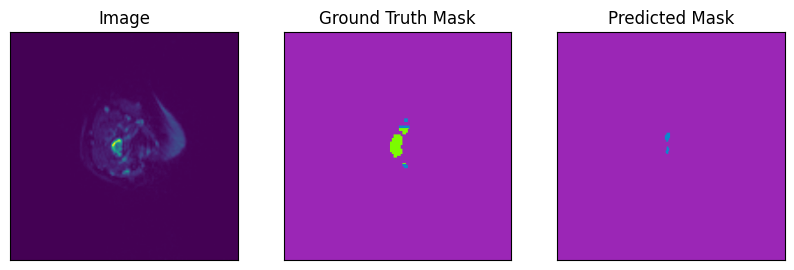

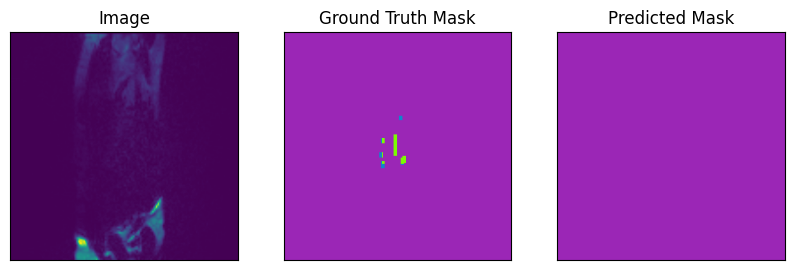

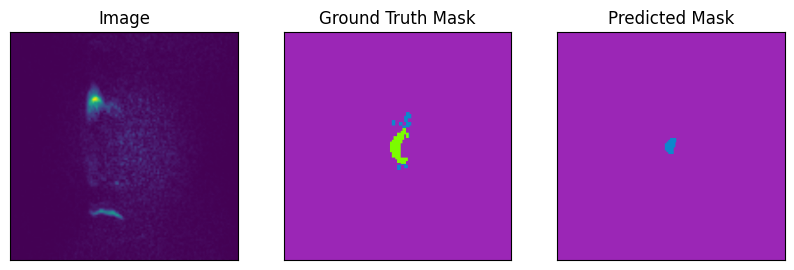

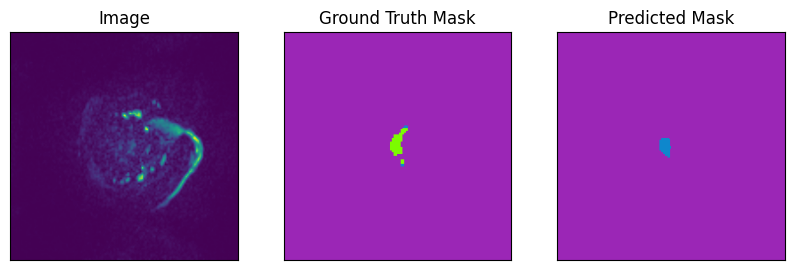

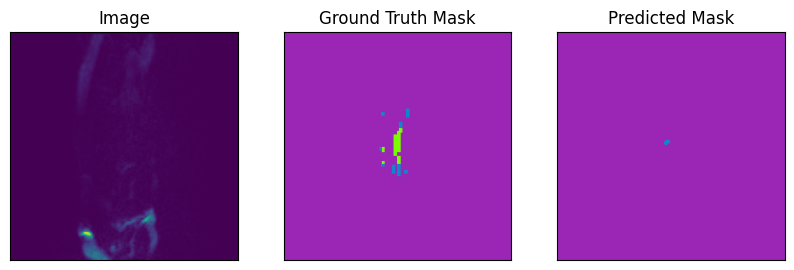

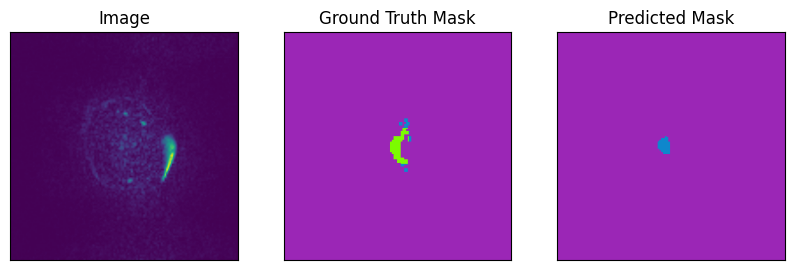

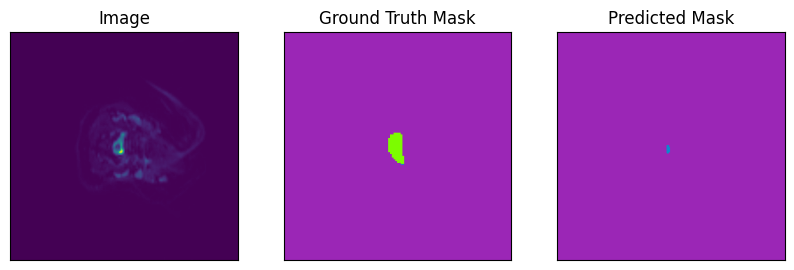

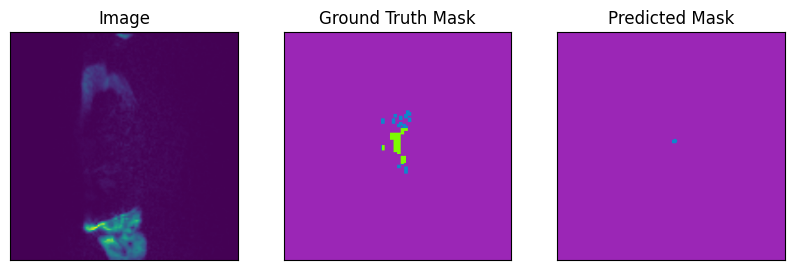

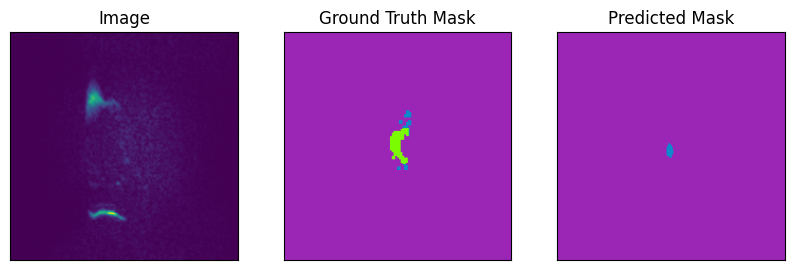

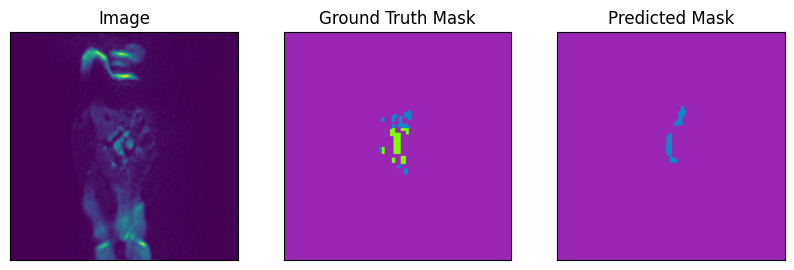

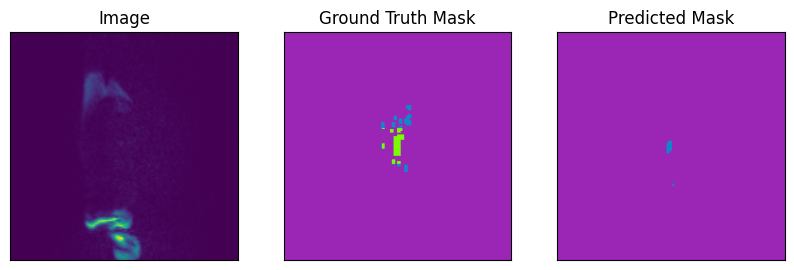

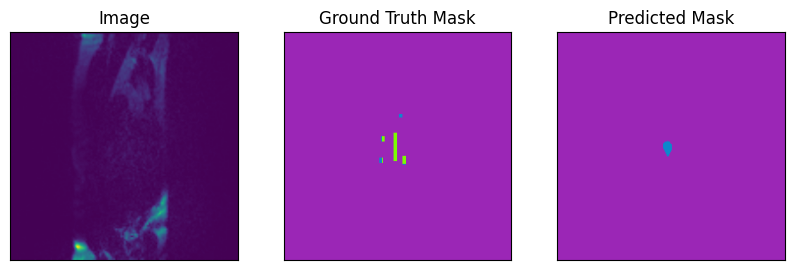

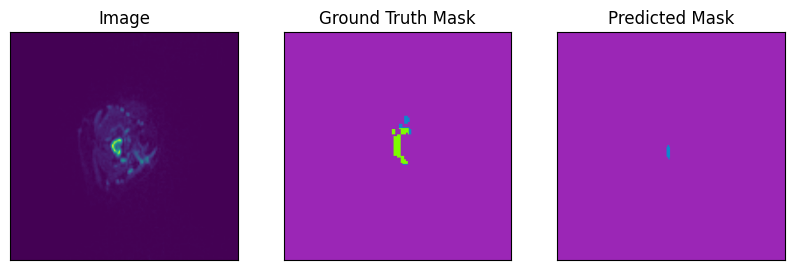

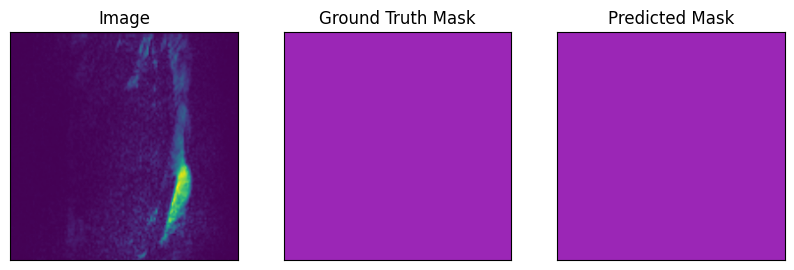

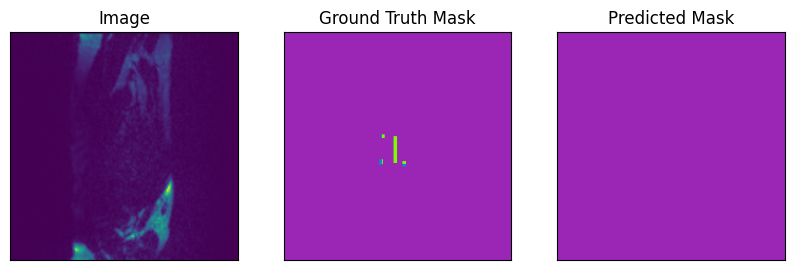

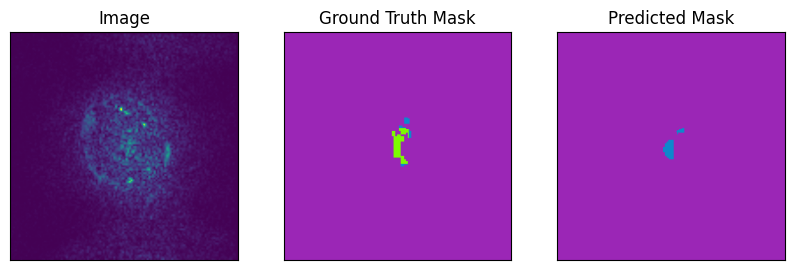

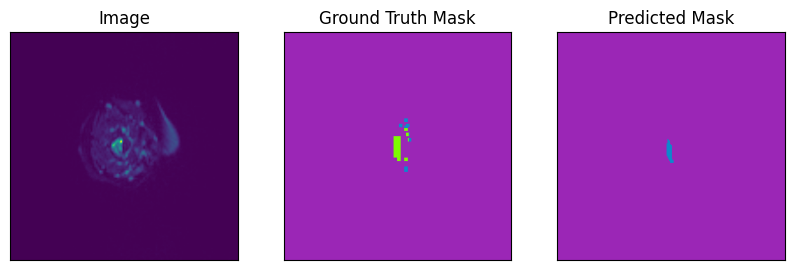

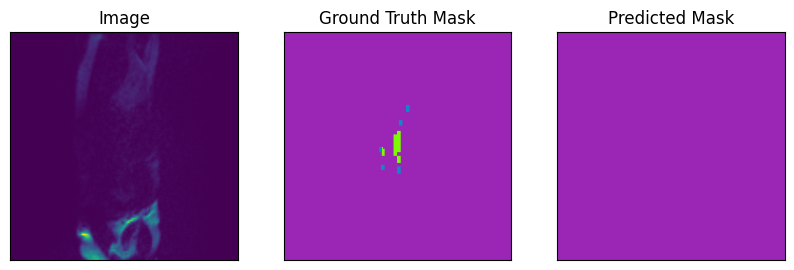

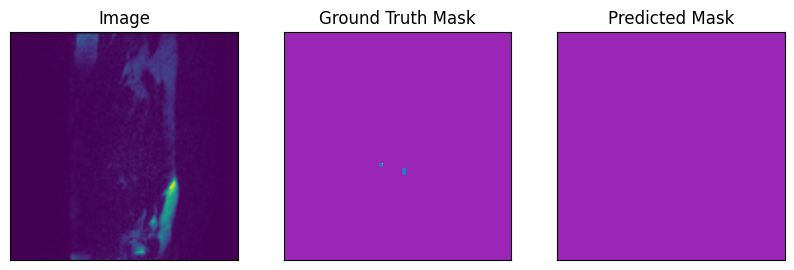

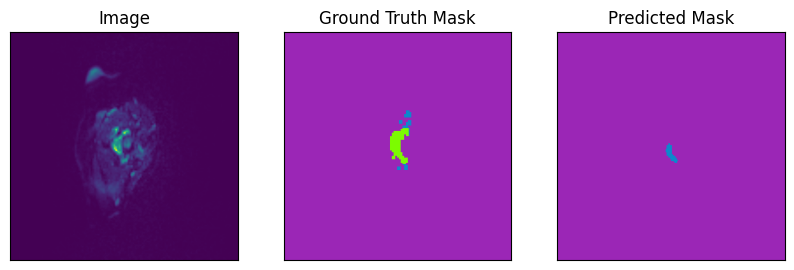

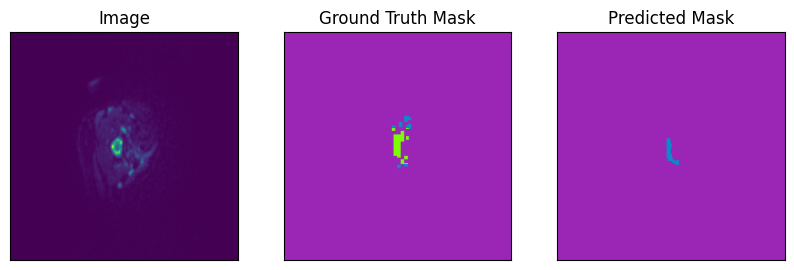

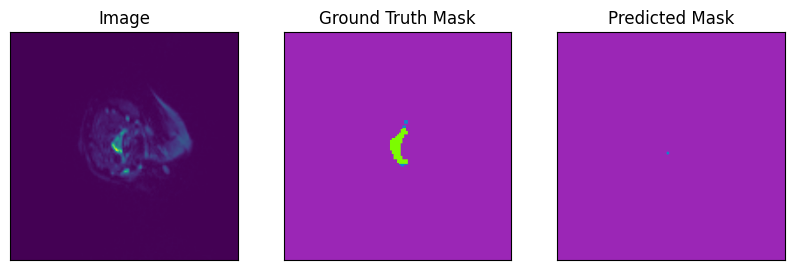

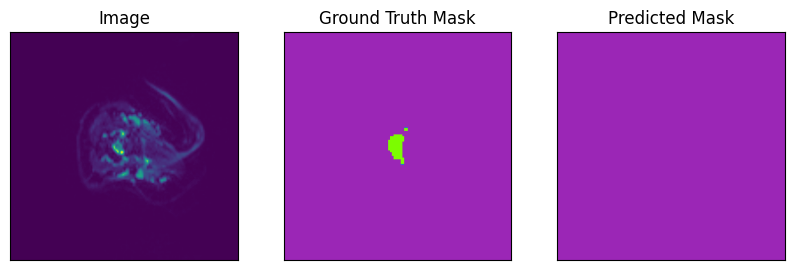

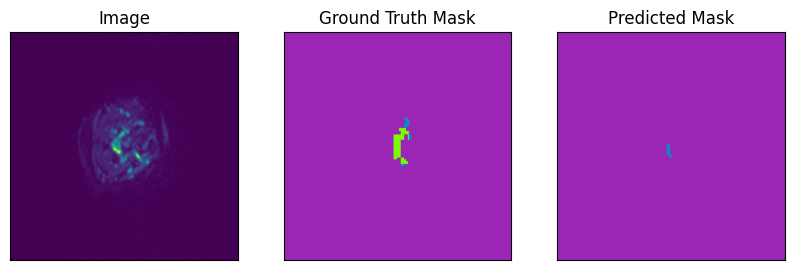

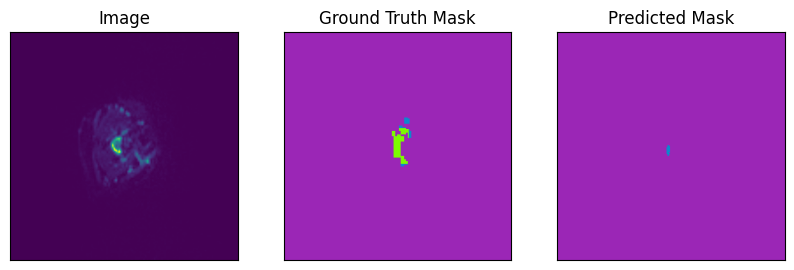

In [ ]:
# from PIL import Image
# import random
model=multi_model
model.eval()


random.seed(10)
samples = random.sample(range(len(valid_dataset)), 60)

palette = [[155,38,182], [14,135,204], [124,252,0], [255,20,147], [169,169,169]]
pal = [value for color in palette for value in color]

cols = ['Image', 'Mask', 'Prediction']
model.to(device)
model.eval()

for i in range(len(samples)):
        image, mask, image_org = valid_dataset[samples[i]]
        # image_np,_ =train_dataset_np[samples[i]]

        pred = torch.argmax(model(torch.tensor(image).unsqueeze(0).to(device)), 1)

        mask = Image.fromarray(mask.squeeze(0)).convert('P')

        ################ IMPORTANT ####################################################
        ##  In below code line, '>0' is converting multi-segment predictions back to binary ##
        ################ IMPORTANT ####################################################

        pred = Image.fromarray(np.array(pred.squeeze(0).cpu()>0.5).astype('uint8')).convert('P')
        mask.putpalette(pal)
        pred.putpalette(pal)
        visualize(image=cv2.cvtColor(image_org.astype('uint8'), cv2.COLOR_BGR2GRAY), ground_truth_mask=mask,predicted_mask=pred)
        # axes[i, 0].imshow(cv2.cvtColor(image.transpose(1,2,0).astype('uint8'), cv2.COLOR_BGR2GRAY));
        # axes[i, 1].imshow(mask);
        # axes[i, 2].imshow(pred);

# fig.savefig(arch + '.png')

### Evaluation Results

In [ ]:
model=multi_model
model.eval()
from tqdm import tqdm
with torch.no_grad():

    outputs = []
    test_loss = 0.0
    iou = 0

    for image, mask,_ in (valid_loader):

        image = image.to(device); mask = mask.to(device)
        output = model(image).to(device)
        tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(output, 1).unsqueeze(1), mask.long(), mode='multiclass',num_classes=3)
        outputs.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
        loss = criterion(output, mask.long())
        test_loss += loss.item()

    tp = torch.cat([x["tp"] for x in outputs])
    fp = torch.cat([x["fp"] for x in outputs])
    fn = torch.cat([x["fn"] for x in outputs])
    tn = torch.cat([x["tn"] for x in outputs])

    print(f'Test Loss: {test_loss / len(valid_loader)}')
    print('IoU:', smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise").item())

    # Assuming tp, fp, fn, tn are tensors containing counts for each class
    tp_total = tp.sum().item()
    fp_total = fp.sum().item()
    fn_total = fn.sum().item()
    tn_total = tn.sum().item()

    # Calculate precision, recall, F1 score, accuracy and dice
    precision = tp_total / (tp_total + fp_total)
    recall = tp_total / (tp_total + fn_total)
    #f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp_total + tn_total) / (tp_total + fp_total + fn_total + tn_total)
    epsilon = 1e-10  # A small epsilon value
    dice = (2 * tp / (2 * tp + fp + fn + epsilon)).mean()
    #dice = (2 * tp / (2 * tp + fp + fn)).mean()  # Calculate the mean dice coefficient
    # Print the calculated metrics
    print('Precision:', precision)
    print('Recall:', recall)
    #print('F1 score:', f1_score)
    print('Accuracy:', accuracy)
    print('Mean Dice coefficient:', dice.item())  # Convert the mean dice tensor to a scalar

Test Loss: 0.5034005514931732
IoU: 0.45968273282051086
Precision: 0.9943022909043711
Recall: 0.9943022909043711
Accuracy: 0.9962015272695807
Mean Dice coefficient: 0.4379141330718994


## Binary Segmentation Model

### Training Class

In [ ]:
# !pip install -q segmentation-models-pytorch
# !pip install -q pytorch-lightning
# !pip install -q tabulate
# from PIL import Image

# from pytorch_lightning.loggers import TensorBoardLogger

# import segmentation_models_pytorch as smp
# import pytorch_lightning as pl



from tabulate import tabulate
class BpsModelBinary(pl.LightningModule):
    def __init__(self, model, optimizer, criterion,classes=1,mode='binary'):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_classses=classes
        self.train_avg_loss=[]
        self.train_avg_iou=[]
        self.val_avg_loss=[]
        self.val_avg_iou=[]
        self.final_batch=None



    def forward(self, x):
        return self.model(x)

    def shared_step(self, batch, stage):
        self.final_batch=batch
        image, mask,_ = batch

        assert mask.ndim == 4
        assert mask.max() <= 1.0 and mask.min() >= 0

        out = self.forward(image)
        loss = self.criterion(out, mask.long())

        prob_mask = out.sigmoid()
        pred_mask = (prob_mask > 0.5).float()
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro-imagewise")

        self.log(f"{stage}_IoU", iou, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_loss", loss)
        if stage=="train":
          self.train_avg_loss.append(loss.item())
          self.train_avg_iou.append(iou.item())
        else:
          self.val_avg_loss.append(loss.item())
          self.val_avg_iou.append(iou.item())



        return {"loss": loss, "iou": 1}

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def configure_optimizers(self):
        return self.optimizer

    def on_train_epoch_end(self):
        # log epoch metric

        train_epoch_metrics['loss'].append(np.mean(self.train_avg_loss))
        train_epoch_metrics['IoU'].append(np.mean(self.train_avg_iou))

    def on_validation_epoch_end(self):
        # image, mask = self.final_batch[0]

        val_epoch_metrics['loss'].append(np.mean(self.val_avg_loss))
        val_epoch_metrics['IoU'].append(np.mean(self.val_avg_iou))



### Training and Model Settings

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
arch = 'unetplusplus'
enc_name = 'resnext50_32x4d'
classes = 1
encoder_weights = "imagenet"
mode='binary'
model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
criterion = smp.losses.DiceLoss(mode=mode, from_logits=True).to(device)
cbs = pl.callbacks.ModelCheckpoint(dirpath = f'./checkpoints_{arch}',
                                   filename = arch,
                                   verbose = True,
                                   monitor = 'valid_loss',
                                   mode = 'min')

preprocessing_fn = smp.encoders.get_preprocessing_fn(enc_name, encoder_weights)

### Dataloaders

In [ ]:
train_dataset = Dataset(
    train_slices,
    binary_mask_train,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=classes,
)

valid_dataset = Dataset(
    val_slices,
    binary_mask_val,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=classes,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Training

In [ ]:
train_epoch_metrics={'loss':[],'dice_similarity':[],'IoU':[]}
val_epoch_metrics={'loss':[],'dice_similarity':[],'IoU':[]}


binary_model = BpsModelBinary(model, optimizer, criterion)
trainer = pl.Trainer(callbacks=cbs, accelerator=device, max_epochs=30, )
trainer.fit(binary_model, train_loader, valid_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/checkpoints_unetplusplus exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type         | Params
-------------------------------------------
0 | model     | UnetPlusPlus | 48.5 M
1 | criterion | DiceLoss     | 0     
-------------------------------------------
48.5 M    Trainable params
0         Non-trainable params
48.5 M    Total params

Sanity Checking: 0it [00:00, ?it/s]

AssertionError: ignored

### Plots

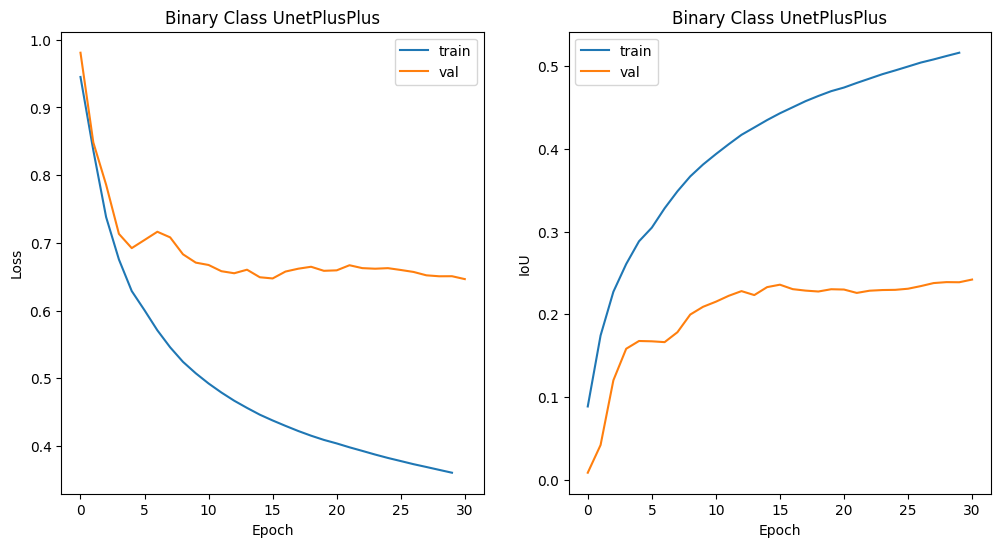

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_epoch_metrics['loss'], label='train')
plt.plot(val_epoch_metrics['loss'], label='val')
plt.title('Binary Class UnetPlusPlus')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2,2)
plt.plot( train_epoch_metrics['IoU'], label='train')
plt.plot( val_epoch_metrics['IoU'], label='val')
plt.title('Binary Class UnetPlusPlus')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()

### Visualization

In [ ]:
#best_model_ckpt='/content/drive/MyDrive/checkpoints_unet_binary/unet-v2.ckpt'
best_model_ckpt = '/content/checkpoints_unetplusplus/unetplusplus-v1.ckpt'
from collections import OrderedDict
binary_model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

state_dict = torch.load(best_model_ckpt)['state_dict']
pl_state_dict = OrderedDict([(key[6:], state_dict[key]) for key in state_dict.keys()])

binary_model.load_state_dict(pl_state_dict)


<All keys matched successfully>

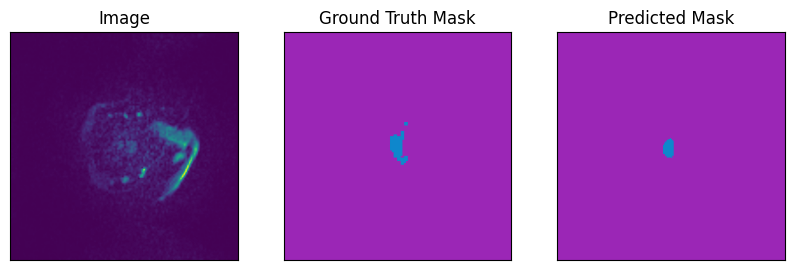

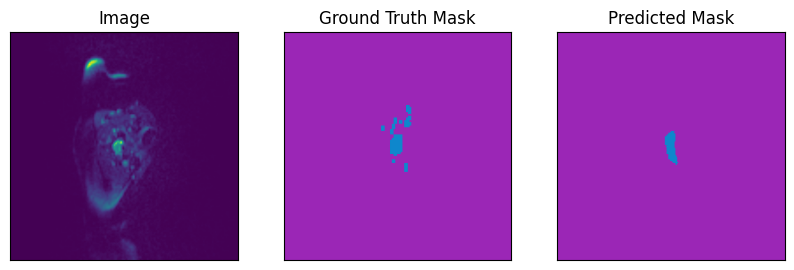

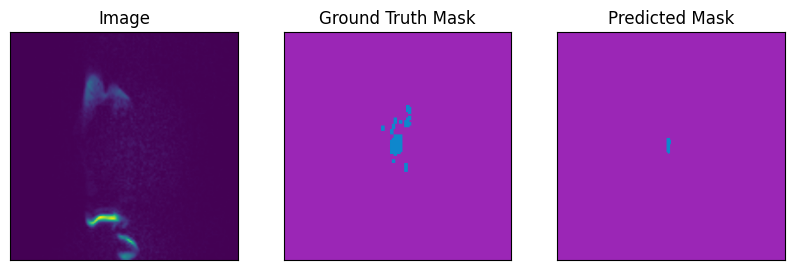

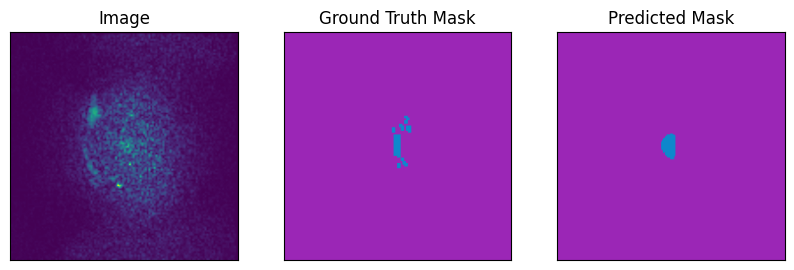

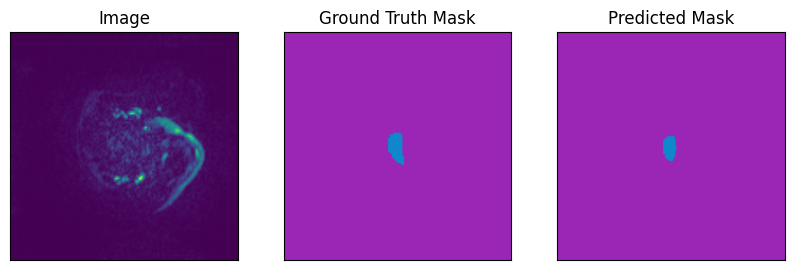

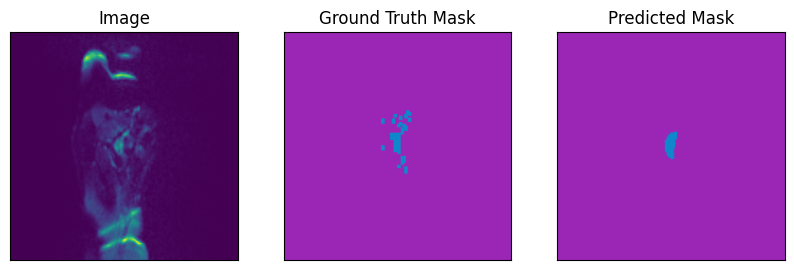

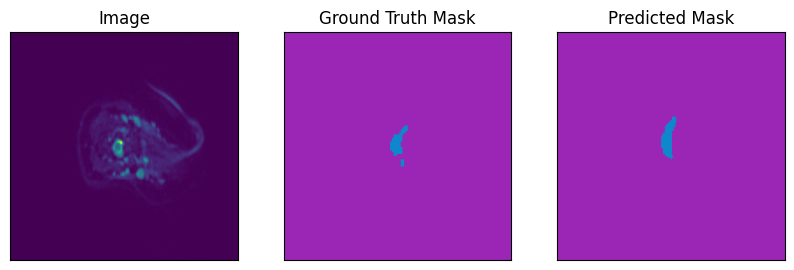

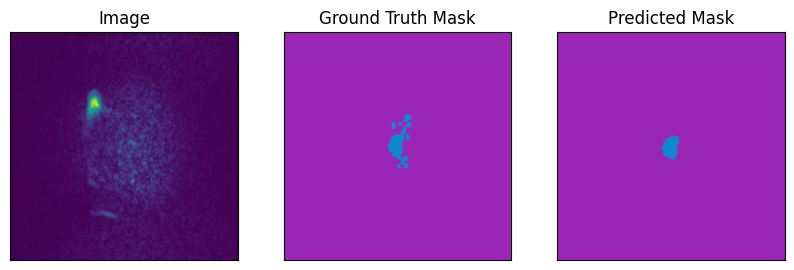

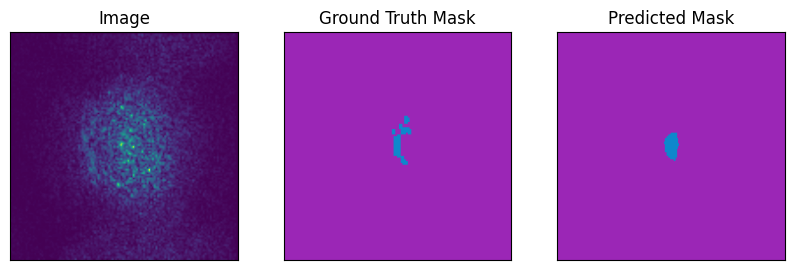

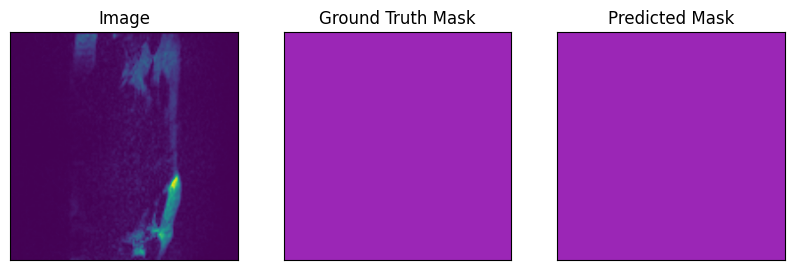

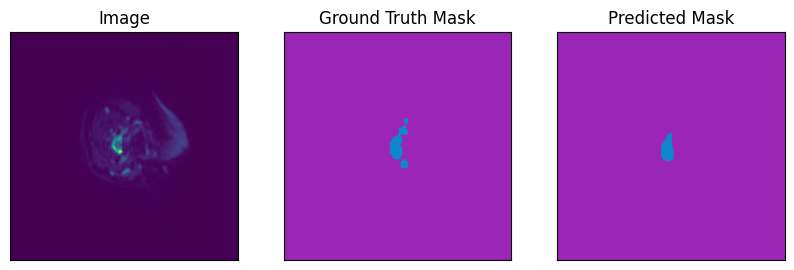

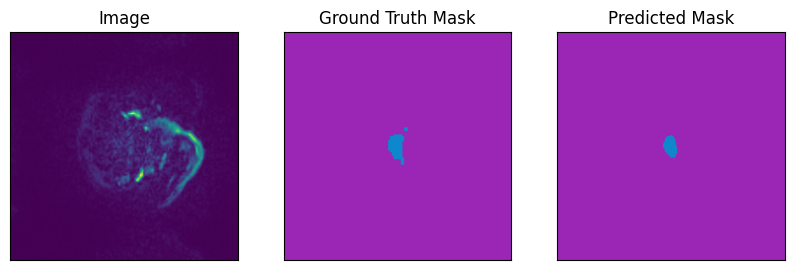

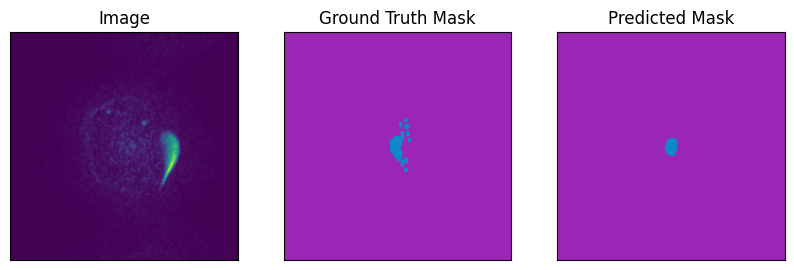

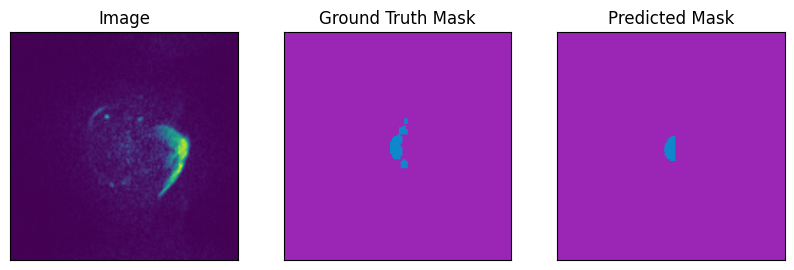

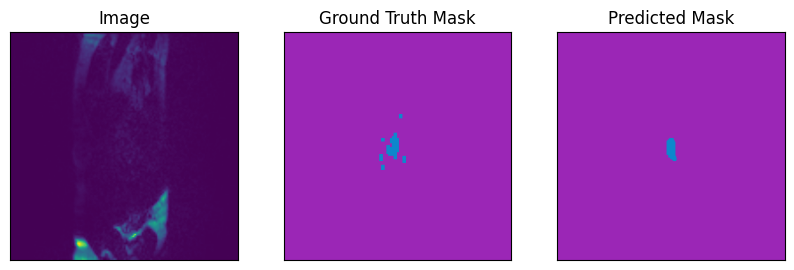

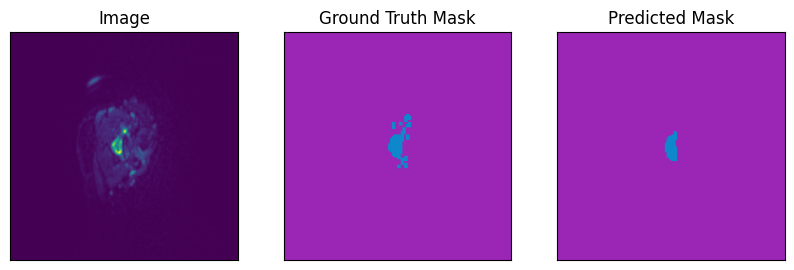

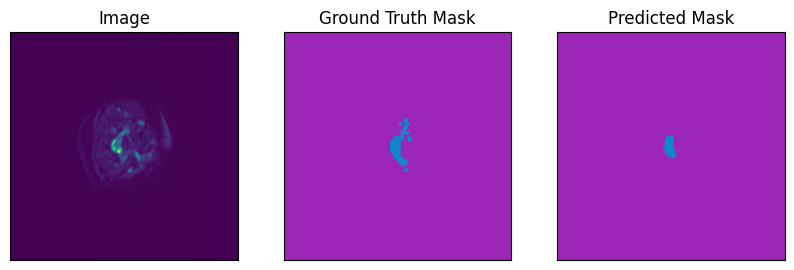

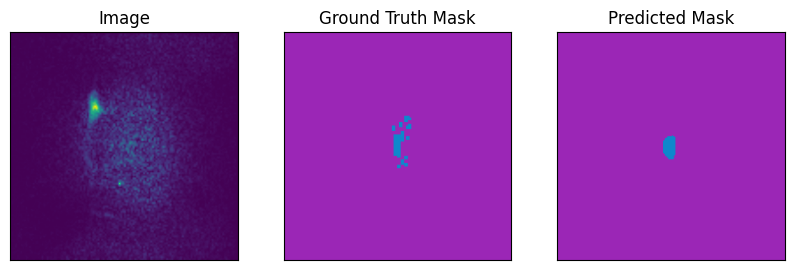

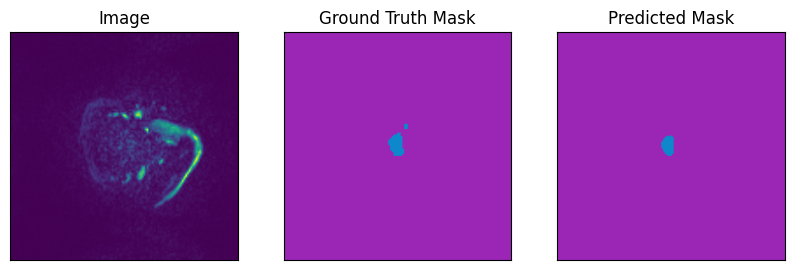

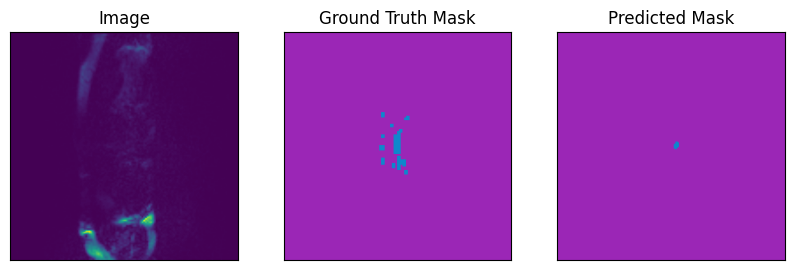

In [ ]:
from PIL import Image
import random

pl_state_dict = OrderedDict([(key[6:], state_dict[key]) for key in state_dict.keys()])

model.load_state_dict(pl_state_dict)
model.eval()
model.to(device)
random.seed(10)
samples = random.sample(range(len(valid_dataset)), 20)

palette = [[155,38,182], [14,135,204], [124,252,0], [255,20,147], [169,169,169]]
pal = [value for color in palette for value in color]

cols = ['Image', 'Mask', 'Prediction']

for i in range(len(samples)):
        image, mask, image_org = valid_dataset[samples[i]]
        # image_np,_ =train_dataset_np[samples[i]]

        pred = model(torch.tensor(image).unsqueeze(0).to(device))

        prob = pred.sigmoid()
        pred = (prob > 0.5)

        mask = Image.fromarray(mask.squeeze(0)).convert('P')
        pred = Image.fromarray(np.array(pred.squeeze(0).squeeze(0).cpu()).astype('uint8')).convert('P')
        mask.putpalette(pal)
        pred.putpalette(pal)
        visualize(image=cv2.cvtColor(image_org.astype('uint8'), cv2.COLOR_BGR2GRAY), ground_truth_mask=mask,predicted_mask=pred)

# fig.savefig(arch + '.png')

### Evalution Results

In [ ]:
model=binary_model
model.eval()
from tqdm import tqdm
with torch.no_grad():

    outputs = []
    test_loss = 0.0
    iou = 0

    for image, mask,_ in valid_loader:

        image = image.to(device); mask = mask.to(device)
        output = model(image).to(device)

        prob_mask = output.sigmoid()
        pred_mask = (prob_mask > 0.5).float()
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        outputs.append({"tp": tp, "fp": fp, "fn": fn, "tn": tn})
        loss = criterion(output, mask.long())
        test_loss += loss.item()

    tp = torch.cat([x["tp"] for x in outputs])
    fp = torch.cat([x["fp"] for x in outputs])
    fn = torch.cat([x["fn"] for x in outputs])
    tn = torch.cat([x["tn"] for x in outputs])

    print(f'Test Loss: {test_loss / len(valid_loader)}')
    print('IoU:', smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item())

    # Assuming tp, fp, fn, tn are tensors containing counts for each class
    tp_total = tp.sum().item()
    fp_total = fp.sum().item()
    fn_total = fn.sum().item()
    tn_total = tn.sum().item()

    # Calculate precision, recall, F1 score, accuracy and dice
    precision = tp_total / (tp_total + fp_total)
    recall = tp_total / (tp_total + fn_total)
    #f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp_total + tn_total) / (tp_total + fp_total + fn_total + tn_total)
    epsilon = 1e-10  # A small epsilon value
    dice = (2 * tp / (2 * tp + fp + fn + epsilon)).mean()
    #dice = (2 * tp / (2 * tp + fp + fn)).mean()  # Calculate the mean dice coefficient
    # Print the calculated metrics
    print('Precision:', precision)
    print('Recall:', recall)
    #print('F1 score:', f1_score)
    print('Accuracy:', accuracy)
    print('Mean Dice coefficient:', dice.item())  # Convert the mean dice tensor to a scalar

Test Loss: 0.5039538899554482
IoU: 0.3578949272632599
Precision: 0.7040804597701149
Recall: 0.3639415364505971
Accuracy: 0.9948699564873418
Mean Dice coefficient: 0.408187597990036


## Comparison

In [ ]:
from collections import OrderedDict

device = "cuda" if torch.cuda.is_available() else "cpu"
arch = 'unetplusplus'
enc_name = 'resnext50_32x4d'
classes = 3
encoder_weights = "imagenet"

#best_model_ckpt1='/content/drive/MyDrive/checkpoints_unet_binary/unet-v2.ckpt'
#best_model_ckpt2='/content/drive/MyDrive/BPI_data_clean1/checkpoints_unet_multi/unet-v23.ckpt'

best_model_ckpt2='/content/checkpoints_unetplusplus/unetplusplus.ckpt'
best_model_ckpt1='/content/checkpoints_unetplusplus/unetplusplus-v1.ckpt'
multi_model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

state_dict = torch.load(best_model_ckpt2)['state_dict']
pl_state_dict = OrderedDict([(key[6:], state_dict[key]) for key in state_dict.keys()])

multi_model.load_state_dict(pl_state_dict)

classes = 1
binary_model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

state_dict = torch.load(best_model_ckpt1)['state_dict']
pl_state_dict = OrderedDict([(key[6:], state_dict[key]) for key in state_dict.keys()])

binary_model.load_state_dict(pl_state_dict)

<All keys matched successfully>

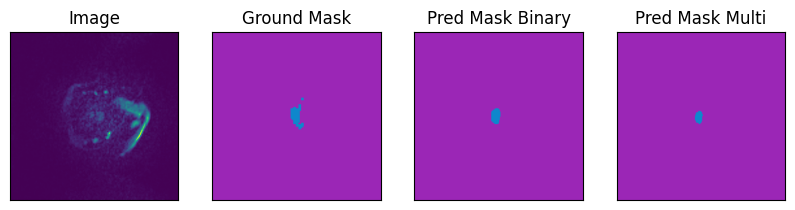

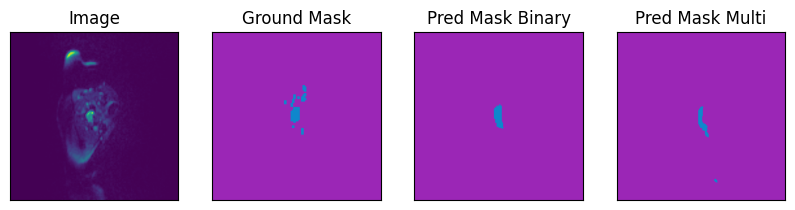

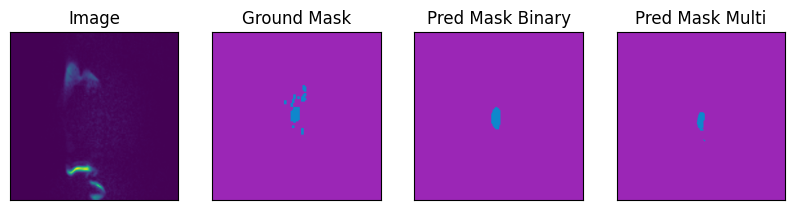

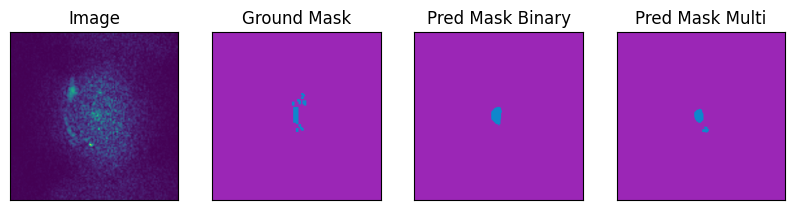

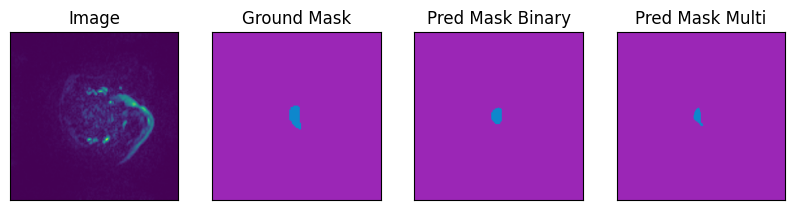

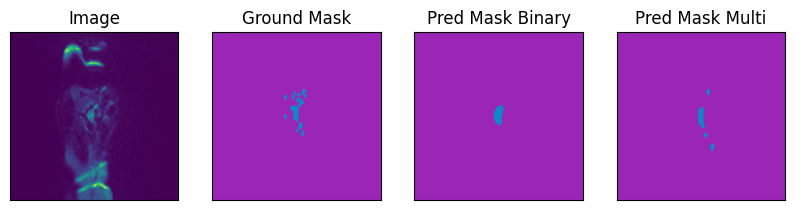

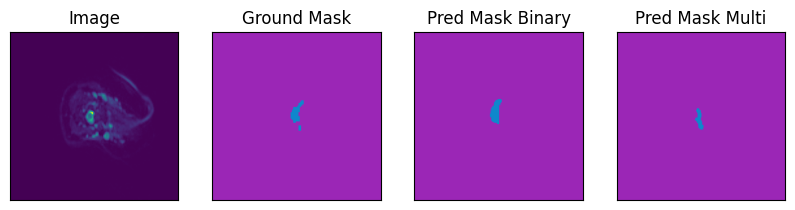

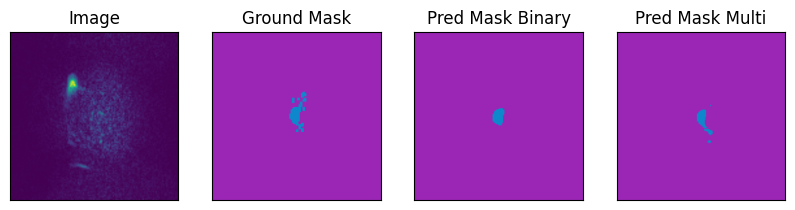

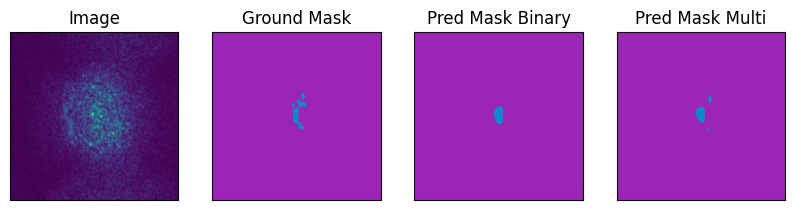

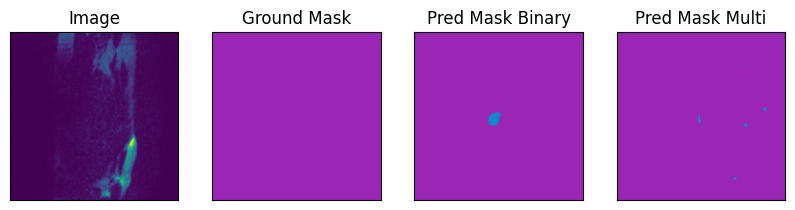

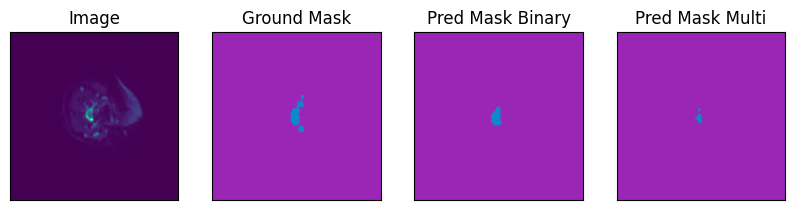

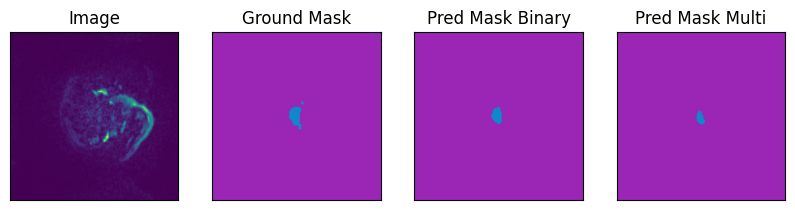

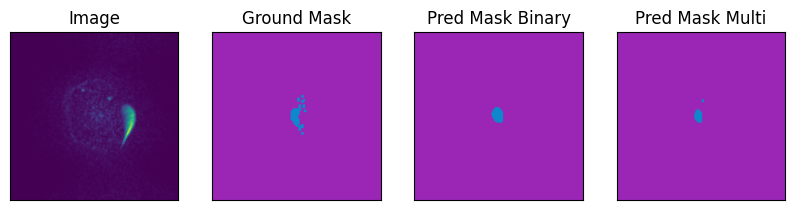

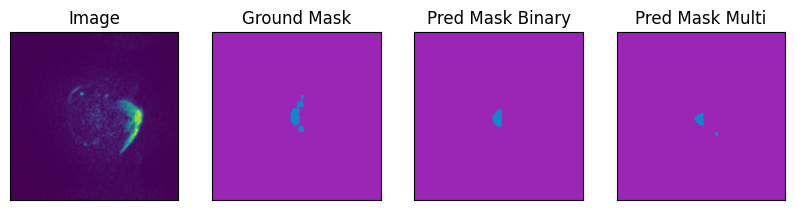

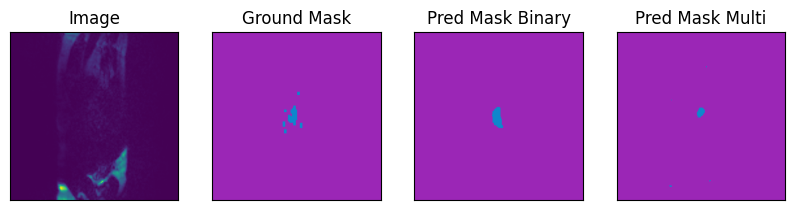

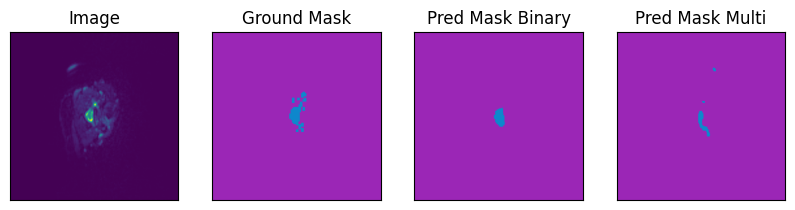

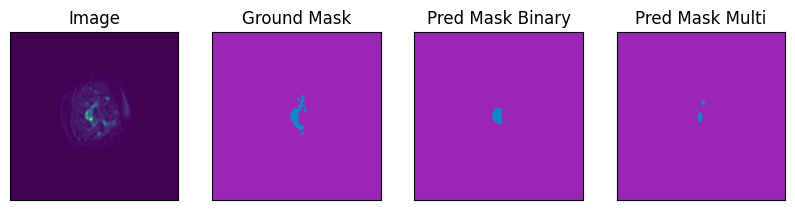

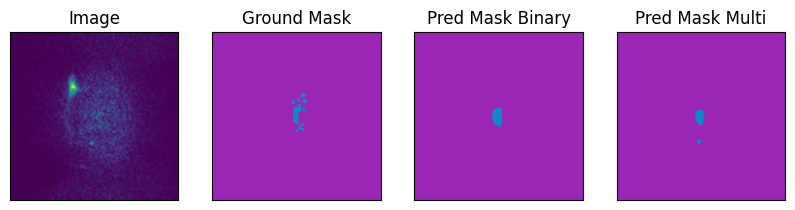

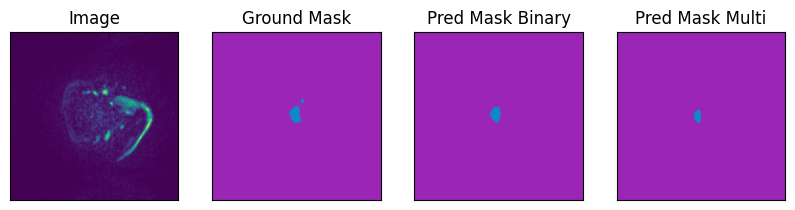

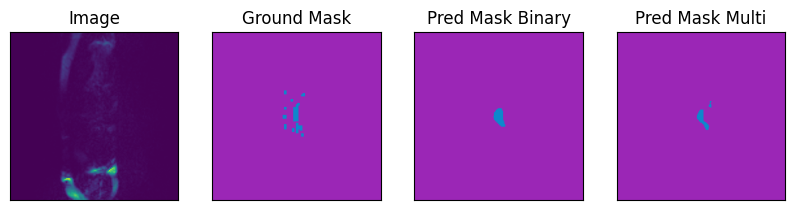

In [ ]:
from PIL import Image
import random
from collections import OrderedDict


random.seed(10)
samples = random.sample(range(len(valid_dataset)), 20)

palette = [[155,38,182], [14,135,204], [124,252,0], [255,20,147], [169,169,169]]
pal = [value for color in palette for value in color]

cols = ['Image', 'Mask', 'Prediction']

for i in range(len(samples)):
        image, mask, image_org = valid_dataset[samples[i]]
        # image_np,_ =train_dataset_np[samples[i]]

        pred = binary_model(torch.tensor(image).unsqueeze(0).to(device))
        prob = pred.sigmoid()
        pred = (prob > 0.5)
        mask = Image.fromarray(mask.squeeze(0)).convert('P')
        pred_binary = Image.fromarray(np.array(pred.squeeze(0).squeeze(0).cpu()).astype('uint8')).convert('P')
        mask.putpalette(pal)
        pred_binary.putpalette(pal)

        pred = torch.argmax(multi_model(torch.tensor(image).unsqueeze(0).to(device)), 1)
        pred_multi = Image.fromarray(np.array(pred.squeeze(0).cpu()>0).astype('uint8')).convert('P')
        pred_multi.putpalette(pal)


        visualize(image=cv2.cvtColor(image_org.astype('uint8'), cv2.COLOR_BGR2GRAY), ground_mask=mask,pred_mask_binary=pred_binary,pred_mask_multi=pred_multi)

# fig.savefig(arch + '.png')

## Make Mask nifti

### Load Models

In [ ]:
from collections import OrderedDict
test_path="/content/drive/MyDrive/BPI_data_clean1/Masked_Dataset/test"

#best_model_ckpt_binary='/content/drive/MyDrive/BPI_data_clean1/checkpoints_unet_binary/unet-v2.ckpt'
#best_model_ckpt_multi='/content/drive/MyDrive/BPI_data_clean1/checkpoints_unet_multi/unet-v23.ckpt'

#best_model_ckpt_binary='/content/checkpoints_unet/unet-v1.ckpt'
#best_model_ckpt_multi='/content/checkpoints_unet/unet.ckpt'

best_model_ckpt_multi='/content/checkpoints_unetplusplus/unetplusplus.ckpt'
best_model_ckpt_binary='/content/checkpoints_unetplusplus/unetplusplus-v1.ckpt'

device = "cuda" if torch.cuda.is_available() else "cpu"
arch = 'unet'
enc_name = 'resnext50_32x4d'
classes = 3
encoder_weights = "imagenet"

multi_model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

state_dict = torch.load(best_model_ckpt_multi)['state_dict']
pl_state_dict = OrderedDict([(key[6:], state_dict[key]) for key in state_dict.keys()])

multi_model.load_state_dict(pl_state_dict)

classes=1

binary_model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

state_dict = torch.load(best_model_ckpt_binary)['state_dict']
pl_state_dict = OrderedDict([(key[6:], state_dict[key]) for key in state_dict.keys()])

binary_model.load_state_dict(pl_state_dict)

preprocessing_fn = smp.encoders.get_preprocessing_fn(enc_name, encoder_weights)


RuntimeError: ignored

### Load Data

In [ ]:
test_path="/content/drive/MyDrive/BPI_data_clean1/Masked_Dataset/test"
test_slices,test_files=load_test(test_path)

slice_shape (124, 136, 47)
slice_shape (130, 130, 47)
slice_shape (130, 130, 47)
slice_shape (130, 130, 50)


### Produce Masked Nifti

In [ ]:

import nibabel as nib
import numpy as np
### directory for the masked files
dir='/content/masked_files/'


def convert_to_nifti(scan_preds,file_name,dir=dir,):
  slices=scan_preds.shape[0]
  temp_nifti=np.zeros(shape=(130,130,slices))
  for i in range(slices):
    temp_nifti[:,:,i]=np.array(cv2.resize(scan_preds[i],(130,130)))
  data = np.arange(4*4*3).reshape(4,4,3)
  new_image = nib.Nifti1Image(temp_nifti, affine=np.eye(4))
  file_path=dir+file_name
  nib.save(new_image, file_path)

def generate_nifti(model=multi_model,test_files=test_files,test_slices=test_slices,classes=3,mode='multi'):

  slice_preds=[]
  for i,test_slice in enumerate(test_slices):
    test_file=test_files[i]

    test_dataset = Dataset(
      test_slice,
      preprocessing=get_preprocessing(preprocessing_fn),
      classes=classes,
    )
    scans_pred=[]
    if mode=='binary':

        for i in range(test_slice.shape[2]):
          image= test_dataset[i]
            # image_np,_ =train_dataset_np[samples[i]
          pred = model(torch.tensor(image).unsqueeze(0).to(device))
          prob = pred.sigmoid()
          pred = (prob > 0.5)
          scans_pred.append(np.array(pred.squeeze(0).squeeze(0).cpu()).astype('uint8'))
    else :
        scans_pred=[]

        for i in range(test_slice.shape[2]):
          image= test_dataset[i]
            # image_np,_ =train_dataset_np[samples[i]
          pred = torch.argmax(multi_model(torch.tensor(image).unsqueeze(0).to(device)), 1)
          prob = np.array(pred.squeeze(0).cpu()>0).astype('uint8')
          scans_pred.append(prob)
    file_name='masked_'+test_file.split('/')[-1]
    convert_to_nifti(np.array(scans_pred),file_name,dir=dir,)
    # slice_preds.append(np.array(scans_pred))

###
generate_nifti()

In [ ]:
# file_no=0
# for i in range(47):
#   visualize(image=test_slices[file_no][:,:,i],mask=scan_preds[file_no][i])